In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import bisect
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
from sklearn.cluster import KMeans

In [9]:
import zipfile
import io
zf = zipfile.ZipFile(io.BytesIO(uploaded['g2-ts.zip']), "r")
zf.extractall()

In [1022]:
!dir data_g2

 Volume in drive C has no label.
 Volume Serial Number is 1EB9-42ED

 Directory of C:\Users\dkushn\cv@ucu2020\Hw3\data_g2

24.10.2020  20:45    <DIR>          .
24.10.2020  20:45    <DIR>          ..
24.10.2020  20:45    <DIR>          g2-gt-pa
24.10.2020  20:43            23я714 g2-gt-pa.zip
24.10.2020  20:44    <DIR>          g2-gt-txt
24.10.2020  20:43            19я554 g2-gt-txt.zip
24.10.2020  20:20    <DIR>          g2-txt
               2 File(s)         43я268 bytes
               5 Dir(s)  299я906я441я216 bytes free


In [3]:
DATA_POINTS_DIR = "data_g2/g2-txt"
DATA_EXPECTED_CLUSTER_CENTER_DIR = "data_g2/g2-gt-txt"

In [4]:
datasets = [f for f in listdir(DATA_POINTS_DIR) if isfile(join(DATA_POINTS_DIR, f))]

In [5]:
def LoadDataFromDir(dirname):
    dataSamples = []
    onlyfiles = [f for f in listdir(dirname) if isfile(join(dirname, f))]
    for filename in tqdm(onlyfiles):
        df = pd.read_csv(join(dirname, filename), header=None, delim_whitespace=True)
        dataSamples.append(df.to_numpy())
    return dataSamples

In [6]:
inputDatasets = LoadDataFromDir(DATA_POINTS_DIR)

In [7]:
inputDatasets[1].shape

(2048, 1)

In [8]:
for dataset in inputDatasets:
    assert(dataset.shape[0] == 2048)

In [9]:
expectedCentroids = LoadDataFromDir(DATA_EXPECTED_CLUSTER_CENTER_DIR)

In [10]:
# All input data have to clusters
for centroids in expectedCentroids:
    assert(centroids.shape[0] == 2)

In [11]:
# datasets and centroids presumably are matched correctly: shapes of data members are matching
for dataset, centroids in zip(inputDatasets, expectedCentroids):
    assert(dataset.shape[1] == centroids.shape[1])

# Running 2d sample code

In [12]:
points = inputDatasets[42]
expected_centroid_pair = expectedCentroids[42]
data_dim = points.shape[1]

# All required info is accumulated in n-dimentional 'histogram' of counted values

In [15]:
values, counts = np.unique(points, return_counts=True, axis=0)

In [16]:
domain_span = (values.min(axis=0), values.max(axis=0))
domain_span

(array([433, 432], dtype=int64), array([667, 658], dtype=int64))

In [17]:
def GetPointDistance(p1, p2):
    pwise_dist = p2 - p1
    return np.sqrt(pwise_dist@pwise_dist)

In [18]:
points.shape

(2048, 2)

In [19]:
def PlaceDataOnSpan(data_span, points):
    canvas = np.zeros((domain_span[1] - domain_span[0]))
    for p in points:
        point_span_pos = p - domain_span[0] - 1
        canvas[ tuple(point_span_pos)  ] += 1
    return canvas

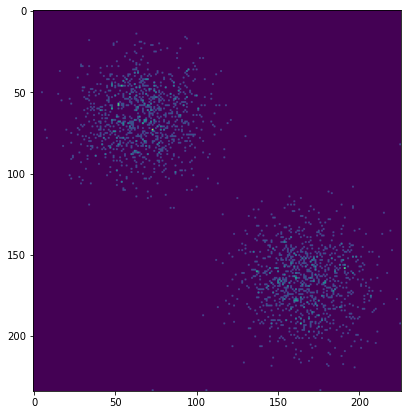

In [20]:
if (data_dim == 1):
    plt.bar(values.flatten(), counts)
elif (data_dim == 2):
    plt.figure(figsize=(7, 7))
    image = PlaceDataOnSpan(domain_span, points)
    plt.imshow(image)
    

In [21]:
print("dim1 span [{}:{}]".format(domain_span[0][0], domain_span[1][0]))

dim1 span [433:667]


In [22]:
# uses simple radial kernel
def MeanShiftIteration(values, counts, domain_span, kernelR, initPos, verbose=True):
    kernelLowerLim = np.maximum(domain_span[0][0], initPos[0]-kernelR)
    kernelUpperLim = np.minimum(domain_span[1][0], initPos[0]+kernelR)
    
    boundingBoxLowIndex = bisect.bisect_left(values[:,0], kernelLowerLim)
    boundingBoxHightIndex = bisect.bisect_right(values[:,0], kernelUpperLim)
    
    if verbose:
        print("KernelLowerLimit = ", kernelLowerLim)
        print("KernelUpeprLimit = ", kernelUpperLim)
        print("clusterCenter =", initPos)
        print("lowerLimFirstDim =", boundingBoxLowIndex)
        print("upperLimFirstDim =", boundingBoxHightIndex)
        print("usedCluster R = ", kernelR)
    
    n_points = 0
    sum_points = np.zeros_like(values[0])
    
    n_points2 = 0
    sum_points2 = np.zeros_like(values[0])
    
    kernelRSquared = kernelR * kernelR

    selector = [(p_val - initPos)@(p_val - initPos) < kernelRSquared
                for p_val 
                in values[boundingBoxLowIndex:boundingBoxHightIndex]]
    
    selectedP = counts[boundingBoxLowIndex:boundingBoxHightIndex][selector]
    selectedV = values[boundingBoxLowIndex:boundingBoxHightIndex][selector]
    n_points = np.sum(selectedP)
    
    sum_points = selectedP @ selectedV
    
    #Note: used type in64 is large enough as accumulator for given dataset.
    if n_points != 0:
        newMeanPoint = sum_points / n_points
    else:
        newMeanPoint = initPos
    
    if verbose:
        print("pointsInSpan =", n_points)
        print("accum = ", sum_points)
        print("meanPoints =", newMeanPoint)
    
    return newMeanPoint

In [23]:
def MeanShift(points, values, counts, initialPos, domain_span, usedRadius, max_iter, verbose=False):

    domain_range = domain_span[1] - domain_span[0]

    convergence_criterion = 1
    shiftDistance = 2
    it = 0
    max_color = counts.max()
    history = []
    while shiftDistance > 0 and it < max_iter:
        updatedPos = MeanShiftIteration(values, counts, domain_span, usedRadius, initialPos, verbose=False)
        shift = updatedPos - initialPos
        shiftDistance = np.sqrt(shift@shift)
        history.append((initialPos, updatedPos))
        initialPos = updatedPos
        it += 1

    if (verbose):
        print("domain_range_from = ", domain_span[0])
        print("domain_range_to = ", domain_span[1])
        print("domain_range = ", domain_range)
        if shift.sum() < convergence_criterion:
            print("Converged in {} iterations".format(it))
        
    return initialPos, history

In [24]:
def Draw2DConvergence(points, counts, domain_span, means_history):
    assert(points.shape[1] == 2)
    max_color = counts.max()
    canvas = Draw2dData(domain_span, points)
    for initialPos, updatedPos in means_history:
        displayedCenter = initialPos - domain_span[0]
        iPosDisp = initialPos - domain_span[0]
        nPosDisp = updatedPos - domain_span[0]

        shift = updatedPos - initialPos
        shift_len = np.sqrt(shift@shift)

        canvas = cv2.line(canvas, 
                 (int(iPosDisp[0]), int(iPosDisp[1])),
                 (int(nPosDisp[0]), int(nPosDisp[1])),
                 color = shift_len // max_color,
                 thickness=2
                )
    plt.imshow(canvas)
    plt.show()

In [25]:
points.shape

(2048, 2)

In [26]:
npEps = np.finfo(np.float64).eps

In [27]:
# Expected that in few iterations such heuristics will find several very distant points in dataset.
def GetRadius2(points):
    p = points[0]
    data_diagonal_len = 0
    least_required_distance = 0
    
    for i in range(4):
        distances = [GetPointDistance(p, p2) for p2 in points]
        distant_point_index = np.argmax(distances)
        p = points[distant_point_index]
        
        print(sorted(distances)[:5])
        # Inclusion of several points seems reasonable requirement.
        
        # 
        least_required_distance = max(least_required_distance,
                                      distances[np.argsort(distances)[1]] + npEps) # Eps is used to include that point.
        
    print("LeastRequired R:", least_required_distance)

    return least_required_distance

In [28]:
def RunMeanShiftOnDataset(points, values, counts, domain_span, kernelRadius, max_iter=10, visualizeHistory=False):
    clustered_regions = []
    
    for data_point in tqdm(points):
    #     initialPose = np.random.uniform(low=domain_span[0], high=domain_span[1])

        finalMeanPos, history = MeanShift(points,
                                          values,
                                          counts,
                                          data_point,
                                          domain_span,
                                          kernelRadius,
                                          max_iter=max_iter)
        clustered_regions.append((data_point, finalMeanPos))
        if(visualizeHistory):
            print(initialPose)
            print(finalMeanPos)
            Draw2DConvergence(points, counts, domain_span, history)
    return clustered_regions

In [29]:
number_of_points = points.shape[0]
kernelRadius = GetRadius2(points)

# kernelRaius = GetRadius(domain_span, number_of_points)
print("UsedRadius :", kernelRadius)
clustered_regions = RunMeanShiftOnDataset(points,
                                          values,
                                          counts,
                                          domain_span,
                                          kernelRadius,
                                          visualizeHistory=False)

[0.0, 3.0, 4.47213595499958, 4.47213595499958, 4.47213595499958]
[0.0, 14.866068747318506, 15.132745950421556, 15.620499351813308, 17.4928556845359]
[0.0, 10.04987562112089, 13.0, 17.029386365926403, 17.46424919657298]
[0.0, 14.866068747318506, 15.132745950421556, 15.620499351813308, 17.4928556845359]
LeastRequired R: 14.866068747318506
UsedRadius : 14.866068747318506


In [30]:
def GroupClusteredRegions(clustered_regions, acceptance_distance):
    groups=[]
    for p_init, p_converged in tqdm(clustered_regions):
        hasGroup = False
        for group in groups:
            if hasGroup:
                break
            for _, gp in group:
                dist = GetPointDistance(p_converged, gp)
                if dist < acceptance_distance:
                    hasGroup = True
                    group.append((p_init, p_converged))
                    break
        if not hasGroup:
            groups.append([ (p_init, p_converged) ])
    return groups

In [31]:
def GroupPoints(points, group_distance):
    groups=[]
    for p in tqdm(points):
        hasGroup = False
        for group in groups:
            if hasGroup:
                break
            for gp in group:
                dist = GetPointDistance(p, gp)
                if dist < group_distance:
                    hasGroup = True
                    group.append(p)
                    break
        if not hasGroup:
            groups.append([p])
    return groups

In [32]:
grouped_regions = GroupClusteredRegions(clustered_regions, 10)
[len(gr_r) for gr_r in grouped_regions]

[1001, 7, 9, 3, 1, 1, 1, 1, 1020, 1, 2, 1]

In [33]:
# Selecting 2 largest clusters and merge all the others to them.
def MergeGroups2(groups):
    group_sizes = [len(gr)for gr in groups]
    sorted_sizes_idx = np.argsort(group_sizes)
    
    largest_idx = sorted_sizes_idx[-1]
    second_largest_idx = sorted_sizes_idx[-2]

    # Use mean for each group as position.
    group_means = [ np.mean([c for i, c in gr], axis=0) for gr in groups ]
    
    # Spread into two domains
    groups_to_second = []
    groups_to_first = []
    for i_gr, gr in enumerate(groups):
        if i_gr == largest_idx or i_gr == second_largest_idx:
            continue
        
        dist_to_largest = GetPointDistance(group_means[i_gr], group_means[largest_idx])
        dist_to_second_largest = GetPointDistance(group_means[i_gr], group_means[second_largest_idx])
        if dist_to_largest < dist_to_second_largest:
            groups_to_first.append(gr)
        else:
            groups_to_second.append(gr)
            
    merged_groups = [groups[largest_idx].copy(), groups[second_largest_idx].copy()]
    for gr in groups_to_first:
        merged_groups[0].extend(gr)
    for gr in groups_to_second:
        merged_groups[1].extend(gr)

    return merged_groups

In [34]:
# On each oteration finding smallest group, then group closest to it with larger size. Megre smaller into larger.
# Strategy is not optimal, because has some misses on delimiting line, yet working.
def MergeGroups(groups):
    n_groups = len(groups)
    while n_groups > 2:
        group_sizes = [len(gr)for gr in groups]
        sg_idx = np.argmin(group_sizes)
        sg_size = group_sizes[sg_idx]
        
#         converged_pts = [c for i, c in groups]
        group_means = [ np.mean([c for i, c in gr], axis=0) for gr in groups ]
        sg_mean = group_means[sg_idx]
        
        
        distances_to_smallest = [(GetPointDistance(sg_mean, g_mean), g_id) \
                                 for g_id, g_mean in enumerate(group_means)\
                                if sg_size != group_sizes[g_id]]
        merge_to = np.argmin(distances_to_smallest)
        groups[merge_to].extend(groups.pop(sg_idx))
        n_groups = len(groups)
    return groups

In [35]:
merged_groups = MergeGroups2(grouped_regions)
[len(gr_r) for gr_r in merged_groups]

[1024, 1024]

In [36]:
def DisplayInintConvergedPairs(points, domain_span, clustered_regions):
    assert(domain_span[0].shape[0] == 2)
    plt.figure(figsize=(10, 10))
    
    canvas =  PlaceDataOnSpan(domain_span, points)

    for init_p, converged_p in clustered_regions:
        disp_init = init_p - domain_span[0]
        disp_conv = converged_p - domain_span[0]

        cv2.line(canvas,
                (int(disp_init[0]), int(disp_init[1])),
                (int(disp_conv[0]), int(disp_conv[1])),
                 1,
                 1)
    for init_p, converged_p in clustered_regions:
        disp_init = init_p - domain_span[0]
        disp_conv = converged_p - domain_span[0]

        cv2.circle(canvas,
                (int(disp_conv[0]), int(disp_conv[1])),
                 1,
                 3)
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas)
    return canvas

<Figure size 720x720 with 0 Axes>

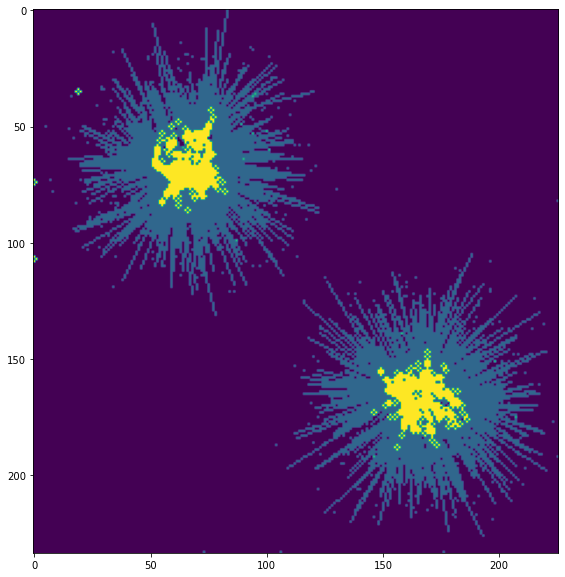

In [37]:
if data_dim == 2:
    DisplayInintConvergedPairs(points, domain_span, clustered_regions)

In [38]:
cluster_candidates = [el[1] for el in clustered_regions]

In [39]:
def GetPointDistance(p1, p2):
    pwise_dist = p2 - p1
    return np.sqrt(pwise_dist@pwise_dist)

In [41]:
predicted_cluster_centroids = []
predicted_cluster_centroids.append(np.round(np.mean(merged_groups[0], axis=0)))
predicted_cluster_centroids.append(np.round(np.mean(merged_groups[1], axis=0)))

In [48]:
predicted_cluster_centroids[1]

array([[500., 499.],
       [499., 500.]])

In [49]:
expected_centroid_pair

array([[500, 500],
       [600, 600]], dtype=int64)

In [50]:
centroids_error = expected_centroid_pair - predicted_cluster_centroids
print("Centroids error :", centroids_error.flatten())

# Centroids assignment should be reversed if initial guess is not correct

Centroids error : [-100.  -99.    1.    2.    0.    1.  101.  100.]


In [52]:
resulting_clusters = np.zeros( (points.shape[0]) )
first_cluster_init_points = [ initPoint for initPoint, _ in merged_groups[0]]
second_cluster_init_points = [ initPoint for initPoint, _ in merged_groups[1]]
for i_p, p in enumerate(points):
    if  (first_cluster_init_points == p).all(axis=1).any():
        resulting_clusters[i_p] = 1
    else:
        resulting_clusters[i_p] = 2

In [53]:
def CheckAssignment(points, myPA):
    
    # Getting correct labels from the points indices (we were reading them maintaining order)
    expectedPA = np.array([ 1 if i < points.shape[0]//2 else 2 for i in range(points.shape[0]) ]) 
    
    n_assigned_correctly = (expectedPA == myPA).sum()
    
    # Indexes id should be changed.
    if (n_assigned_correctly < expectedPA.size // 2):
        expectedPA = np.flip(expectedPA)
        n_assigned_correctly = (expectedPA == myPA).sum()
    
    n_missasigned = expectedPA.size - n_assigned_correctly
    
    return n_assigned_correctly, n_missasigned

In [54]:
correct_assignments, missasigned = CheckAssignment(points,
                                                   resulting_clusters)


print("AssignedCorrectly: ", correct_assignments)
print("Missasigned: ", missasigned)

AssignedCorrectly:  2048
Missasigned:  0


# Run on all datasets


Processing:  g2-1-10.txt
DataDim : 1
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 2.0, 3.0, 3.0]
[0.0, 1.0, 1.0, 1.0, 2.0]
[0.0, 1.0, 2.0, 3.0, 3.0]
LeastRequired R: 1.0000000000000002
kernel R: 1.0000000000000002
Clustering...



GroupsLen:  54
Groups: [121, 119, 115, 113, 113]
Score: 0.016528925619834656
MergedGroups: [1024, 1024]
2
Centroids error : [0. 0.]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-1-100.txt
DataDim : 1
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.0, 35.0, 42.0]
[0.0, 57.0, 106.0, 143.0, 158.0]
[0.0, 0.0, 1.0, 35.0, 42.0]
LeastRequired R: 57.0
kernel R: 57.0
Clustering...



GroupsLen:  23
Groups: [1717, 144, 51, 23, 21]
Score: 0.9161327897495632
MergedGroups: [1869, 179]
new kernelRadius : 51.81818181818181



GroupsLen:  26
Groups: [1696, 162, 84, 17, 14]
Score: 0.9044811320754716
MergedGroups: [1839, 209]
new kernelRadius : 47.10743801652892



GroupsLen:  31
Groups: [1650, 141, 54, 27, 25]
Score: 0.9145454545454546
MergedGroups: [1812, 236]
new kernelRadius : 42.82494365138992



GroupsLen:  39
Groups: [1372, 211, 151, 96, 36]
Score: 0.8462099125364432
MergedGroups: [1637, 411]
new kernelRadius : 38.93176695580902



GroupsLen:  41
Groups: [1007, 475, 169, 74, 56]
Score: 0.5283018867924528
MergedGroups: [1374, 674]
new kernelRadius : 35.39251541437183



GroupsLen:  43
Groups: [1080, 361, 122, 75, 72]
Score: 0.6657407407407407
MergedGroups: [1333, 715]
new kernelRadius : 32.175014013065294



GroupsLen:  45
Groups: [558, 441, 343, 136, 95]
Score: 0.20967741935483875
MergedGroups: [989, 1059]
new kernelRadius : 29.250012739150264



GroupsLen:  51
Groups: [769, 233, 186, 167, 157]
Score: 0.6970091027308192
MergedGroups: [1367, 681]
OldScore2 0.6657407407407407 OldScore1 0.20967741935483875 score 0.6970091027308192
2
Centroids error : [ 25. -16.]
AssignedCorrectly:  1423
Missasigned:  625

Processing:  g2-1-20.txt
DataDim : 1
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 18.0, 18.0, 19.0, 21.0]
[0.0, 3.0, 3.0, 11.0, 16.0]
[0.0, 18.0, 18.0, 19.0, 21.0]
LeastRequired R: 18.0
kernel R: 18.0
Clustering...



Groups: [1021, 1019, 5, 2, 1]
Score: 0.0019588638589618235
MergedGroups: [1024, 1024]
2
Centroids error : [0. 0.]
AssignedCorrectly:  2036
Missasigned:  12

Processing:  g2-1-30.txt
DataDim : 1
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 4.0, 18.0, 19.0, 21.0]
[0.0, 6.0, 10.0, 10.0, 16.0]
[0.0, 4.0, 18.0, 19.0, 21.0]
LeastRequired R: 6.0
kernel R: 6.0
Clustering...



GroupsLen:  48
Groups: [313, 244, 182, 164, 140]
Score: 0.2204472843450479
MergedGroups: [944, 1104]
new kernelRadius : 5.454545454545454



GroupsLen:  51
Groups: [405, 229, 224, 197, 130]
Score: 0.4345679012345679
MergedGroups: [900, 1148]
new kernelRadius : 4.958677685950413



GroupsLen:  56
Groups: [292, 184, 156, 143, 141]
Score: 0.36986301369863017
MergedGroups: [1104, 944]
new kernelRadius : 4.507888805409466



GroupsLen:  57
Groups: [290, 219, 187, 149, 128]
Score: 0.2448275862068966
MergedGroups: [879, 1169]
new kernelRadius : 4.098080732190423



GroupsLen:  52
Groups: [273, 234, 171, 171, 149]
Score: 0.1428571428571429
MergedGroups: [1104, 944]
new kernelRadius : 3.7255279383549302



GroupsLen:  61
Groups: [203, 164, 151, 150, 141]
Score: 0.1921182266009852
MergedGroups: [1049, 999]
new kernelRadius : 3.3868435803226635



GroupsLen:  77
Groups: [180, 174, 158, 125, 118]
Score: 0.033333333333333326
MergedGroups: [999, 1049]
new kernelRadius : 3.0789487093842394



GroupsLen:  75
Groups: [175, 125, 115, 113, 109]
Score: 0.2857142857142857
MergedGroups: [964, 1084]
OldScore2 0.1921182266009852 OldScore1 0.033333333333333326 score 0.2857142857142857
2
Centroids error : [2. 0.]
AssignedCorrectly:  1943
Missasigned:  105

Processing:  g2-1-40.txt
DataDim : 1
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 4.0, 7.0, 9.0]
[0.0, 13.0, 16.0, 16.0, 24.0]
[0.0, 0.0, 4.0, 7.0, 9.0]
LeastRequired R: 13.0
kernel R: 13.0
Clustering...



GroupsLen:  34
Groups: [560, 527, 236, 200, 146]
Score: 0.05892857142857144
MergedGroups: [999, 1049]
new kernelRadius : 11.818181818181817



GroupsLen:  35
Groups: [498, 369, 365, 237, 133]
Score: 0.25903614457831325
MergedGroups: [1034, 1014]
2
Centroids error : [ 1. -3.]
AssignedCorrectly:  1852
Missasigned:  196

Processing:  g2-1-50.txt
DataDim : 1
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 23.0, 23.0, 30.0, 31.0]
[0.0, 29.0, 33.0, 46.0, 46.0]
[0.0, 23.0, 23.0, 30.0, 31.0]
LeastRequired R: 29.0
kernel R: 29.0
Clustering...



GroupsLen:  20
Groups: [1735, 91, 76, 61, 22]
Score: 0.947550432276657
MergedGroups: [1946, 102]
new kernelRadius : 26.36363636363636



GroupsLen:  22
Groups: [752, 672, 220, 86, 75]
Score: 0.1063829787234043
MergedGroups: [1135, 913]
new kernelRadius : 23.966942148760324



GroupsLen:  24
Groups: [699, 498, 283, 193, 146]
Score: 0.28755364806866957
MergedGroups: [1133, 915]
new kernelRadius : 21.78812922614575



GroupsLen:  29
Groups: [693, 617, 187, 132, 106]
Score: 0.10966810966810969
MergedGroups: [1106, 942]
new kernelRadius : 19.807390205587044



GroupsLen:  30
Groups: [534, 368, 332, 299, 185]
Score: 0.31086142322097376
MergedGroups: [952, 1096]
OldScore2 0.28755364806866957 OldScore1 0.10966810966810969 score 0.31086142322097376
2
Centroids error : [ 3. 10.]
AssignedCorrectly:  1704
Missasigned:  344

Processing:  g2-1-60.txt
DataDim : 1
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 23.0, 49.0, 49.0, 52.0]
[0.0, 51.0, 54.0, 58.0, 62.0]
[0.0, 23.0, 49.0, 49.0, 52.0]
LeastRequired R: 51.0
kernel R: 51.0
Clustering...



Groups: [1999, 30, 5, 4, 3, 2, 2, 1, 1, 1]
Score: 0.984992496248124
MergedGroups: [2008, 40]
new kernelRadius : 46.36363636363636



Groups: [1949, 62, 9, 7, 5, 5, 3, 2, 1, 1, 1, 1, 1, 1]
Score: 0.9681888147768086
MergedGroups: [1960, 88]
new kernelRadius : 42.148760330578504



Groups: [1896, 46, 42, 25, 14, 5, 5, 4, 3, 3, 1, 1, 1, 1, 1]
Score: 0.9757383966244726
MergedGroups: [1992, 56]
new kernelRadius : 38.31705484598046



Groups: [1808, 60, 57, 44, 31, 10, 9, 5, 5, 4, 3, 3, 2, 2, 1, 1, 1, 1, 1]
Score: 0.9668141592920354
MergedGroups: [1886, 162]
new kernelRadius : 34.83368622361859



Groups: [800, 710, 294, 115, 83, 10, 7, 5, 4, 4, 4, 2, 2, 2, 2, 1, 1, 1, 1]
Score: 0.11250000000000004
MergedGroups: [1205, 843]
new kernelRadius : 31.6669874760169



GroupsLen:  25
Groups: [665, 563, 331, 220, 104]
Score: 0.1533834586466165
MergedGroups: [1210, 838]
new kernelRadius : 28.788170432742632



GroupsLen:  32
Groups: [615, 550, 338, 185, 153]
Score: 0.10569105691056913
MergedGroups: [1183, 865]
new kernelRadius : 26.171064029766026



GroupsLen:  35
Groups: [501, 457, 286, 262, 224]
Score: 0.08782435129740518
MergedGroups: [1116, 932]
new kernelRadius : 23.791876390696384



GroupsLen:  33
Groups: [470, 415, 385, 258, 186]
Score: 0.11702127659574468
MergedGroups: [817, 1231]
OldScore2 0.10569105691056913 OldScore1 0.08782435129740518 score 0.11702127659574468
2
Centroids error : [-5.  0.]
AssignedCorrectly:  1642
Missasigned:  406

Processing:  g2-1-70.txt
DataDim : 1
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 27.0, 39.0, 39.0, 40.0]
[0.0, 3.0, 20.0, 28.0, 39.0]
[0.0, 27.0, 39.0, 39.0, 40.0]
LeastRequired R: 27.0
kernel R: 27.0
Clustering...



GroupsLen:  41
Groups: [713, 497, 224, 207, 81]
Score: 0.302945301542777
MergedGroups: [1211, 837]
new kernelRadius : 24.545454545454543



GroupsLen:  38
Groups: [724, 495, 238, 169, 89]
Score: 0.3162983425414365
MergedGroups: [973, 1075]
new kernelRadius : 22.314049586776857



GroupsLen:  42
Groups: [506, 477, 256, 205, 156]
Score: 0.05731225296442688
MergedGroups: [1049, 999]
new kernelRadius : 20.285499624342595



GroupsLen:  41
Groups: [464, 416, 315, 253, 109]
Score: 0.10344827586206895
MergedGroups: [1050, 998]
new kernelRadius : 18.441363294856902



GroupsLen:  48
Groups: [471, 333, 279, 216, 118]
Score: 0.29299363057324845
MergedGroups: [698, 1350]
OldScore2 0.05731225296442688 OldScore1 0.10344827586206895 score 0.29299363057324845
2
Centroids error : [10. -5.]
AssignedCorrectly:  1555
Missasigned:  493

Processing:  g2-1-80.txt
DataDim : 1
[0.0, 0.0, 1.0, 2.0, 2.0]
[0.0, 0.0, 30.0, 32.0, 55.0]
[0.0, 8.0, 21.0, 22.0, 25.0]
[0.0, 0.0, 30.0, 32.0, 55.0]
LeastRequired R: 8.0
kernel R: 8.0
Clustering...



GroupsLen:  75
Groups: [163, 154, 135, 135, 124]
Score: 0.05521472392638038
MergedGroups: [1089, 959]
new kernelRadius : 7.2727272727272725



GroupsLen:  72
Groups: [209, 149, 140, 139, 138]
Score: 0.2870813397129187
MergedGroups: [1092, 956]
new kernelRadius : 6.611570247933884



GroupsLen:  91
Groups: [180, 127, 117, 114, 111]
Score: 0.2944444444444444
MergedGroups: [884, 1164]
OldScore2 0.05521472392638038 OldScore1 0.2870813397129187 score 0.2944444444444444
2
Centroids error : [ 30. -20.]
AssignedCorrectly:  1498
Missasigned:  550

Processing:  g2-1-90.txt
DataDim : 1
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 7.0, 23.0, 25.0, 35.0]
[0.0, 22.0, 46.0, 46.0, 56.0]
[0.0, 7.0, 23.0, 25.0, 35.0]
LeastRequired R: 22.0
kernel R: 22.0
Clustering...



GroupsLen:  46
Groups: [472, 470, 279, 143, 116]
Score: 0.004237288135593209
MergedGroups: [786, 1262]
new kernelRadius : 20.0



GroupsLen:  58
Groups: [396, 350, 275, 225, 122]
Score: 0.11616161616161613
MergedGroups: [1271, 777]
new kernelRadius : 18.18181818181818



GroupsLen:  54
Groups: [481, 362, 276, 151, 81]
Score: 0.24740124740124736
MergedGroups: [1319, 729]
OldScore2 0.004237288135593209 OldScore1 0.11616161616161613 score 0.24740124740124736
2
Centroids error : [  9. -45.]
AssignedCorrectly:  1436
Missasigned:  612

Processing:  g2-1024-10.txt
DataDim : 1024
[0.0, 416.6581332459502, 422.7658926640133, 426.1572479730927, 427.5394718619557]
[0.0, 429.9069666800016, 430.551971311246, 431.73950479426827, 432.6257042756475]
[0.0, 427.3417835877976, 430.0267433544105, 430.677373447921, 431.54605779684744]
[0.0, 429.9069666800016, 430.551971311246, 431.73950479426827, 432.6257042756475]
LeastRequired R: 429.9069666800016
kernel R: 429.9069666800016
Clustering...



GroupsLen:  368
Groups: [874, 808, 1, 1, 1]
Score: 0.07551487414187641
MergedGroups: [1024, 1024]
2
Centroids error : [0.49511719 0.49609375]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-1024-100.txt
DataDim : 1024
[0.0, 4219.333833675643, 4231.092648477459, 4239.2731688344875, 4242.936247458828]
[0.0, 4292.912531137806, 4329.09170612035, 4340.052303832294, 4342.860347743178]
[0.0, 4316.068349783168, 4349.431801971379, 4372.16948436357, 4380.06529631694]
[0.0, 4402.28565633808, 4453.968342949914, 4459.57475551201, 4464.168679608781]
LeastRequired R: 4402.28565633808
kernel R: 4402.28565633808
Clustering...



Groups: [2044, 1, 1, 1, 1]
Score: 0.9995107632093934
MergedGroups: [2047, 1]
new kernelRadius : 4002.0778693982543



GroupsLen:  2048
Groups: [1, 1, 1, 1, 1]
Score: 0.0
MergedGroups: [1735, 313]
new kernelRadius : 4402.28565633808



Groups: [2044, 1, 1, 1, 1]
Score: 0.9995107632093934
MergedGroups: [2047, 1]
OldScore2 0.9995107632093934 OldScore1 0.0 score 0.9995107632093934
2
Centroids error : [-41.26953125  48.99511719]
AssignedCorrectly:  1075
Missasigned:  973

Processing:  g2-1024-20.txt
DataDim : 1024
[0.0, 854.8204489832938, 855.8814170199047, 856.8932255538026, 856.9614927171465]
[0.0, 854.002927395451, 856.0478958563008, 856.9836637882895, 857.6840910265271]
[0.0, 855.3847087714393, 858.4433586440051, 859.8999941853704, 865.5749534269115]
[0.0, 854.002927395451, 856.0478958563008, 856.9836637882895, 857.6840910265271]
LeastRequired R: 855.3847087714393
kernel R: 855.3847087714393
Clustering...



GroupsLen:  560
Groups: [753, 737, 1, 1, 1]
Score: 0.021248339973439556
MergedGroups: [1024, 1024]
2
Centroids error : [0.50292969 0.49902344]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-1024-30.txt
DataDim : 1024
[0.0, 1278.2851794494059, 1283.5984574624574, 1284.6692181258177, 1291.962073746749]
[0.0, 1309.5189956621477, 1316.1040992261971, 1318.899541284324, 1319.505968156264]
[0.0, 1302.7908504437694, 1307.0382549872058, 1307.151865698856, 1308.5369692905126]
[0.0, 1309.5189956621477, 1316.1040992261971, 1318.899541284324, 1319.505968156264]
LeastRequired R: 1309.5189956621477
kernel R: 1309.5189956621477
Clustering...



GroupsLen:  38
Groups: [1008, 1004, 1, 1, 1]
Score: 0.003968253968253954
MergedGroups: [1024, 1024]
2
Centroids error : [0.4765625  0.49023438]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-1024-40.txt
DataDim : 1024
[0.0, 1671.8923410315629, 1673.0152420106638, 1674.137987144429, 1677.4945603488554]
[0.0, 1718.514183822758, 1726.8766603321733, 1733.8145806285054, 1735.9262657152233]
[0.0, 1695.2896507676792, 1706.350198523152, 1724.7617226735988, 1725.8064781429]
[0.0, 1763.1242157034767, 1770.2674939115839, 1780.8366011512678, 1782.7826564110387]
LeastRequired R: 1763.1242157034767
kernel R: 1763.1242157034767
Clustering...



Groups: [1023, 1021, 1, 1, 1, 1]
Score: 0.0019550342130987275
MergedGroups: [1024, 1024]
2
Centroids error : [0.49414062 0.48535156]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-1024-50.txt
DataDim : 1024
[0.0, 2093.713925062352, 2094.7952167216727, 2100.2887896667926, 2105.8556455749763]
[0.0, 2126.8754077284357, 2138.251622237196, 2141.8613400498175, 2146.9042829152863]
[0.0, 2132.0598021631567, 2141.299605379873, 2143.9846081537057, 2144.974825027091]
[0.0, 2126.8754077284357, 2138.251622237196, 2141.8613400498175, 2146.9042829152863]
LeastRequired R: 2132.0598021631567
kernel R: 2132.0598021631567
Clustering...



GroupsLen:  794
Groups: [651, 605, 1, 1, 1]
Score: 0.07066052227342545
MergedGroups: [1024, 1024]
2
Centroids error : [0.57226562 0.44726562]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-1024-60.txt
DataDim : 1024
[0.0, 2473.4676064181635, 2504.1888906390427, 2519.643030272344, 2521.839606319165]
[0.0, 2608.1641052663845, 2609.3476196168267, 2617.412844776307, 2629.171732694538]
[0.0, 2638.5376631763284, 2643.031781874747, 2655.9222503680335, 2657.74396810528]
[0.0, 2626.161076552617, 2628.0656384496942, 2628.2060421511856, 2637.0904421350438]
LeastRequired R: 2638.5376631763284
kernel R: 2638.5376631763284
Clustering...



Groups: [1021, 1020, 1, 1, 1, 1, 1, 1, 1]
Score: 0.0009794319294809117
MergedGroups: [1024, 1024]
2
Centroids error : [0.44726562 0.42480469]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-1024-70.txt
DataDim : 1024
[0.0, 2934.1024181169955, 2942.812090501193, 2952.8638641156485, 2959.2438223302925]
[0.0, 3026.6476504542115, 3043.1488626092546, 3048.3165846086263, 3051.3233194795994]
[0.0, 3065.7131307413615, 3078.573858136264, 3079.0116920856276, 3090.8118674548923]
[0.0, 3025.147103861232, 3027.254366583687, 3036.1141282896465, 3040.734779621531]
LeastRequired R: 3065.7131307413615
kernel R: 3065.7131307413615
Clustering...



GroupsLen:  20
Groups: [1015, 1015, 1, 1, 1]
Score: 0.0
MergedGroups: [1024, 1024]
2
Centroids error : [0.44335938 0.58105469]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-1024-80.txt
DataDim : 1024
[0.0, 3391.587681307974, 3392.6245002947203, 3398.0432604662346, 3400.382772571347]
[0.0, 3430.819581382851, 3441.7961880390303, 3454.5872401779056, 3456.5455298607017]
[0.0, 3488.180471248585, 3517.8504800517035, 3519.5870496409093, 3522.4196229296704]
[0.0, 3430.819581382851, 3441.7961880390303, 3454.5872401779056, 3456.5455298607017]
LeastRequired R: 3488.180471248585
kernel R: 3488.180471248585
Clustering...



GroupsLen:  40
Groups: [1007, 1003, 1, 1, 1]
Score: 0.003972194637537285
MergedGroups: [1024, 1024]
2
Centroids error : [0.47851562 0.35449219]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-1024-90.txt
DataDim : 1024
[0.0, 3840.0222655604484, 3874.4109229662254, 3876.5199599640914, 3877.6394881422384]
[0.0, 3809.036623609702, 3923.1807248710834, 3933.9475085465997, 3937.208528894552]
[0.0, 3924.390271112189, 3961.6711120435025, 3974.647279948247, 3975.9307086517492]
[0.0, 3809.036623609702, 3923.1807248710834, 3933.9475085465997, 3937.208528894552]
LeastRequired R: 3924.390271112189
kernel R: 3924.390271112189
Clustering...



GroupsLen:  47
Groups: [1004, 999, 1, 1, 1]
Score: 0.004980079681274896
MergedGroups: [1024, 1024]
2
Centroids error : [0.59960938 0.48144531]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-128-10.txt
DataDim : 128
[0.0, 131.07631364972087, 133.06765196696003, 133.62634470792054, 134.3837787830064]
[0.0, 131.83702059740276, 134.16780537819048, 135.4252561378416, 136.2791253273956]
[0.0, 128.195163715329, 133.96641370134532, 134.40238093129153, 134.79985163196582]
[0.0, 131.83702059740276, 134.16780537819048, 135.4252561378416, 136.2791253273956]
LeastRequired R: 131.83702059740276
kernel R: 131.83702059740276
Clustering...



GroupsLen:  1071
Groups: [493, 486, 1, 1, 1]
Score: 0.014198782961460488
MergedGroups: [1024, 1024]
2
Centroids error : [0.5078125 0.5546875]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-128-100.txt
DataDim : 128
[0.0, 1242.1590075348647, 1257.608842208101, 1267.9763404732755, 1279.8906203265965]
[0.0, 1520.5308283622533, 1521.5860146570749, 1523.3394237660889, 1550.05419260102]
[0.0, 1381.455753906002, 1396.22097105007, 1431.5725619052637, 1432.4964223341012]
[0.0, 1386.720231337237, 1473.7197834052442, 1476.5544351631604, 1489.7466227516677]
LeastRequired R: 1520.5308283622533
kernel R: 1520.5308283622533
Clustering...



Groups: [2046, 1, 1]
Score: 0.9995112414467253
MergedGroups: [2047, 1]
new kernelRadius : 1382.3007530565937



GroupsLen:  282
Groups: [897, 871, 1, 1, 1]
Score: 0.02898550724637683
MergedGroups: [1024, 1024]
2
Centroids error : [-0.3359375  1.4765625]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-128-20.txt
DataDim : 128
[0.0, 269.3696345173301, 272.15436796053814, 272.64262322681685, 284.95087295883127]
[0.0, 287.72382591645066, 292.98122806760165, 294.4673156735735, 298.23313028568776]
[0.0, 258.3176339315611, 271.01475974566404, 271.57135342300006, 273.3166661585056]
[0.0, 287.72382591645066, 292.98122806760165, 294.4673156735735, 298.23313028568776]
LeastRequired R: 287.72382591645066
kernel R: 287.72382591645066
Clustering...



GroupsLen:  37
Groups: [1009, 1004, 1, 1, 1]
Score: 0.0049554013875123815
MergedGroups: [1024, 1024]
2
Centroids error : [0.5546875 0.4609375]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-128-30.txt
DataDim : 128
[0.0, 412.708129311745, 414.64563183518527, 416.4336681873837, 421.0676905201823]
[0.0, 413.12346822711487, 420.74814319257547, 422.97990496003473, 424.27821061185784]
[0.0, 400.13122847385955, 401.8619165832961, 414.0905698032738, 414.64563183518527]
[0.0, 413.12346822711487, 420.74814319257547, 422.97990496003473, 424.27821061185784]
LeastRequired R: 413.12346822711487
kernel R: 413.12346822711487
Clustering...



GroupsLen:  332
Groups: [871, 847, 1, 1, 1]
Score: 0.027554535017221604
MergedGroups: [1024, 1024]
2
Centroids error : [0.484375  0.4140625]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-128-40.txt
DataDim : 128
[0.0, 513.4208799805477, 514.9834948811466, 518.5826838605393, 524.7513696980695]
[0.0, 584.853827892064, 589.417509071456, 593.1112880396056, 596.0201338881095]
[0.0, 553.8700208532684, 568.6369667898844, 571.5015310565668, 577.4478331416614]
[0.0, 523.710798055568, 557.3876568421658, 559.494414628064, 559.4979892725263]
LeastRequired R: 584.853827892064
kernel R: 584.853827892064
Clustering...



Groups: [1017, 1016, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.000983284169124854
MergedGroups: [1024, 1024]
2
Centroids error : [0.578125  0.5390625]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-128-50.txt
DataDim : 128
[0.0, 630.4046319626784, 633.9045669499471, 652.4906129592977, 652.7480371475658]
[0.0, 669.0493255358681, 682.8857884009594, 684.6604998099423, 684.9489032037353]
[0.0, 673.4181464736453, 674.0808556842421, 681.9010192102663, 686.2433970538442]
[0.0, 669.0493255358681, 682.8857884009594, 684.6604998099423, 684.9489032037353]
LeastRequired R: 673.4181464736453
kernel R: 673.4181464736453
Clustering...



GroupsLen:  626
Groups: [719, 705, 1, 1, 1]
Score: 0.01947148817802502
MergedGroups: [1024, 1024]
2
Centroids error : [0.4609375 0.234375 ]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-128-60.txt
DataDim : 128
[0.0, 819.9975609719824, 827.2895502784983, 831.8593631137417, 840.7419342461752]
[0.0, 839.2216632094288, 865.9174325534739, 869.0293435782246, 869.1490090887753]
[0.0, 836.013755867689, 857.5395034632515, 861.5468646568218, 871.5405899899328]
[0.0, 790.5624580006313, 810.2049123524246, 819.7767988910152, 824.1838387156108]
LeastRequired R: 839.2216632094288
kernel R: 839.2216632094288
Clustering...



GroupsLen:  177
Groups: [948, 925, 1, 1, 1]
Score: 0.024261603375527407
MergedGroups: [1024, 1024]
2
Centroids error : [0.4453125 0.28125  ]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-128-70.txt
DataDim : 128
[0.0, 890.601482145634, 920.4249018795613, 927.3489095265061, 942.3237235684985]
[0.0, 1074.6501756385655, 1077.0835622178995, 1082.2028460505915, 1089.2561682175594]
[0.0, 1065.5524388785377, 1082.7857590493145, 1090.337103835323, 1106.0474673358283]
[0.0, 1074.6501756385655, 1077.0835622178995, 1082.2028460505915, 1089.2561682175594]
LeastRequired R: 1074.6501756385655
kernel R: 1074.6501756385655
Clustering...



Groups: [1024, 1023, 1]
Score: 0.0009765625
MergedGroups: [1024, 1024]
2
Centroids error : [0.703125  0.5078125]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-128-80.txt
DataDim : 128
[0.0, 1026.8592892894333, 1028.7332015639429, 1057.9144577894756, 1059.7528013645447]
[0.0, 1094.5163315364464, 1106.5907102447588, 1109.337189496503, 1109.6652648434122]
[0.0, 1091.6203552517698, 1108.2382415347342, 1142.8595714259911, 1167.6416402304262]
[0.0, 1154.7458594859736, 1159.1596093722383, 1170.9355234170666, 1182.8381123382862]
LeastRequired R: 1154.7458594859736
kernel R: 1154.7458594859736
Clustering...



GroupsLen:  30
Groups: [1014, 1006, 1, 1, 1]
Score: 0.007889546351084853
MergedGroups: [1024, 1024]
2
Centroids error : [0.609375 0.15625 ]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-128-90.txt
DataDim : 128
[0.0, 1260.5570197337365, 1270.9063694859665, 1280.0179686238782, 1286.951048020087]
[0.0, 1289.0449953356942, 1324.6308919846313, 1334.0326082971135, 1344.4184616405712]
[0.0, 1226.8308766900188, 1279.3701575384662, 1301.259005732525, 1301.549461219204]
[0.0, 1289.0449953356942, 1324.6308919846313, 1334.0326082971135, 1344.4184616405712]
LeastRequired R: 1289.0449953356942
kernel R: 1289.0449953356942
Clustering...



GroupsLen:  47
Groups: [1004, 999, 1, 1, 1]
Score: 0.004980079681274896
MergedGroups: [1024, 1024]
2
Centroids error : [0.1484375 0.84375  ]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-16-10.txt
DataDim : 16
[0.0, 32.4037034920393, 35.90264614203248, 36.61966684720111, 36.66060555964672]
[0.0, 37.986839826445156, 38.65229618017538, 40.95119045888654, 42.16633728461603]
[0.0, 34.044089061098404, 35.2845575287547, 35.66510900025401, 36.701498607005135]
[0.0, 37.986839826445156, 38.65229618017538, 40.95119045888654, 42.16633728461603]
LeastRequired R: 37.986839826445156
kernel R: 37.986839826445156
Clustering...



GroupsLen:  94
Groups: [982, 974, 1, 1, 1]
Score: 0.008146639511201648
MergedGroups: [1024, 1024]
2
Centroids error : [0.4375 0.5625]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-16-100.txt
DataDim : 16
[0.0, 288.0538144166815, 312.85140242613585, 324.1789629201747, 324.5335113667]
[0.0, 410.31207635164725, 422.5103549026935, 464.14114232634023, 468.21042278018547]
[0.0, 393.2556420447137, 402.68101519689253, 419.1085778172525, 424.6751699828941]
[0.0, 410.31207635164725, 422.5103549026935, 464.14114232634023, 468.21042278018547]
LeastRequired R: 410.31207635164725
kernel R: 410.31207635164725
Clustering...



GroupsLen:  26
Groups: [1017, 996, 5, 5, 3]
Score: 0.020648967551622377
MergedGroups: [1029, 1019]
2
Centroids error : [-7.9375  5.0625]
AssignedCorrectly:  2001
Missasigned:  47

Processing:  g2-16-20.txt
DataDim : 16
[0.0, 61.11464636239009, 63.773035054010094, 64.66838485689897, 66.01514977639603]
[0.0, 77.45966692414834, 79.6994353806851, 86.98850498772812, 94.44575162494075]
[0.0, 61.506097258727124, 68.62215385719105, 73.68853370776216, 73.83765976789893]
[0.0, 77.45966692414834, 79.6994353806851, 86.98850498772812, 94.44575162494075]
LeastRequired R: 77.45966692414834
kernel R: 77.45966692414834
Clustering...



GroupsLen:  67
Groups: [994, 989, 1, 1, 1]
Score: 0.005030181086519092
MergedGroups: [1024, 1024]
2
Centroids error : [0.0625 0.    ]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-16-30.txt
DataDim : 16
[0.0, 79.27799190191436, 81.57205403813245, 82.23138087129512, 84.3741666625514]
[0.0, 130.90072574283155, 143.29340529138108, 145.71204480069588, 148.6875919503709]
[0.0, 133.4541119636259, 134.34656675925888, 137.22244714331543, 137.6117727521886]
[0.0, 109.65856099730654, 116.85888926393234, 117.50319144601988, 123.90318801386832]
LeastRequired R: 133.4541119636259
kernel R: 133.4541119636259
Clustering...



Groups: [1023, 1022, 1, 1, 1]
Score: 0.0009775171065493637
MergedGroups: [1024, 1024]
2
Centroids error : [0.5   0.125]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-16-40.txt
DataDim : 16
[0.0, 134.36889521016388, 135.81605207043827, 139.0, 142.37626206639925]
[0.0, 163.03373883954205, 166.99101772251106, 176.57859439920796, 183.87495751189175]
[0.0, 139.09708839512064, 151.7003625572464, 155.66630977832037, 161.16761461286197]
[0.0, 163.03373883954205, 166.99101772251106, 176.57859439920796, 183.87495751189175]
LeastRequired R: 163.03373883954205
kernel R: 163.03373883954205
Clustering...



GroupsLen:  35
Groups: [1008, 1007, 1, 1, 1]
Score: 0.0009920634920634885
MergedGroups: [1024, 1024]
2
Centroids error : [0.0625 0.9375]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-16-50.txt
DataDim : 16
[0.0, 111.55267813907473, 125.33554962579451, 132.770478646422, 142.83907028540895]
[0.0, 171.55757051205873, 185.6017241299229, 188.19139193916388, 192.76929216034384]
[0.0, 220.17720136290225, 231.24229716900842, 232.56181973832247, 234.7615811839748]
[0.0, 250.3377718203947, 260.8141100477503, 264.0605991055841, 264.24988174074934]
LeastRequired R: 250.3377718203947
kernel R: 250.3377718203947
Clustering...



Groups: [1024, 1022, 1, 1]
Score: 0.001953125
MergedGroups: [1024, 1024]
2
Centroids error : [1.  0.5]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-16-60.txt
DataDim : 16
[0.0, 161.91664522216362, 162.09256614663116, 170.23806859806652, 187.0454490224234]
[0.0, 257.52087294042786, 259.60546989614835, 270.2868846244671, 276.98014369264814]
[0.0, 221.27358631341428, 227.8332723725839, 241.0974906547142, 249.6217137991004]
[0.0, 229.3839575907609, 230.08042072284204, 236.58824991955962, 243.87086746883074]
LeastRequired R: 257.52087294042786
kernel R: 257.52087294042786
Clustering...



Groups: [1023, 1019, 1, 1, 1, 1, 1, 1]
Score: 0.003910068426197455
MergedGroups: [1025, 1023]
2
Centroids error : [ 0.3125 -0.8125]
AssignedCorrectly:  2047
Missasigned:  1

Processing:  g2-16-70.txt
DataDim : 16
[0.0, 168.89345754054537, 170.9005558797279, 195.36120392749427, 200.66638981154767]
[0.0, 346.01878561719735, 348.9025651954998, 349.393760676976, 353.09205598540444]
[0.0, 214.61360627881913, 254.30296891699868, 257.69749707748423, 287.74120316701254]
[0.0, 316.7791028461316, 326.0199380406051, 339.7131142596647, 343.8546204430006]
LeastRequired R: 346.01878561719735
kernel R: 346.01878561719735
Clustering...



Groups: [1024, 1021, 1, 1, 1]
Score: 0.0029296875
MergedGroups: [1025, 1023]
2
Centroids error : [-2.5625  1.8125]
AssignedCorrectly:  2045
Missasigned:  3

Processing:  g2-16-80.txt
DataDim : 16
[0.0, 204.38444167793205, 230.77911517292893, 236.65798106127755, 241.38144087729694]
[0.0, 352.45850819635496, 363.1253227193058, 389.15035654615554, 389.85253622363416]
[0.0, 282.4535360019414, 304.55213018463684, 306.7050700591694, 308.6567672998601]
[0.0, 352.45850819635496, 363.1253227193058, 389.15035654615554, 389.85253622363416]
LeastRequired R: 352.45850819635496
kernel R: 352.45850819635496
Clustering...



Groups: [1023, 1015, 2, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.00782013685239491
MergedGroups: [1028, 1020]
2
Centroids error : [-1.8125  1.75  ]
AssignedCorrectly:  2032
Missasigned:  16

Processing:  g2-16-90.txt
DataDim : 16
[0.0, 256.325964350083, 293.5694125756292, 320.2561474819804, 321.18997493695224]
[0.0, 414.10143684850937, 436.38744253243584, 438.5476028893557, 450.94456422048154]
[0.0, 321.02959365142647, 324.328537134801, 344.37189200049414, 359.94027282314494]
[0.0, 414.10143684850937, 436.38744253243584, 438.5476028893557, 450.94456422048154]
LeastRequired R: 414.10143684850937
kernel R: 414.10143684850937
Clustering...



Groups: [983, 643, 373, 22, 17, 5, 1, 1, 1, 1, 1]
Score: 0.3458799593082401
MergedGroups: [1007, 1041]
2
Centroids error : [-13.6875  12.9375]
AssignedCorrectly:  2013
Missasigned:  35

Processing:  g2-2-10.txt
DataDim : 2
[0.0, 0.0, 1.0, 1.0, 1.0]
[0.0, 5.0, 6.324555320336759, 6.4031242374328485, 10.04987562112089]
[0.0, 13.416407864998739, 13.601470508735444, 14.035668847618199, 15.0]
[0.0, 5.0, 6.324555320336759, 6.4031242374328485, 10.04987562112089]
LeastRequired R: 13.416407864998739
kernel R: 13.416407864998739
Clustering...



Drawing data


<Figure size 720x720 with 0 Axes>

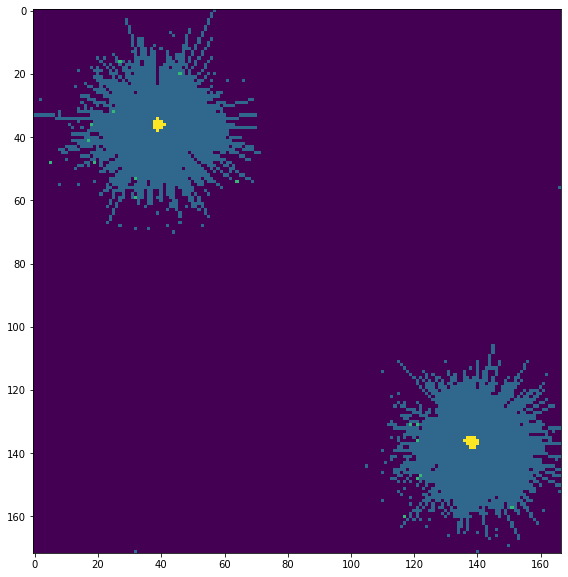


Groups: [1024, 1024]
Score: 0.0
MergedGroups: [1024, 1024]
2
Centroids error : [0.5 1.5]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-2-100.txt
DataDim : 2
[0.0, 6.082762530298219, 7.211102550927978, 7.280109889280518, 11.40175425099138]
[0.0, 101.76934705499491, 157.4325252290644, 161.38463371709216, 169.77926846349644]
[0.0, 63.25345840347388, 71.02816342831905, 120.48651376813922, 127.27922061357856]
[0.0, 101.76934705499491, 157.4325252290644, 161.38463371709216, 169.77926846349644]
LeastRequired R: 101.76934705499491
kernel R: 101.76934705499491
Clustering...



Drawing data


<Figure size 720x720 with 0 Axes>

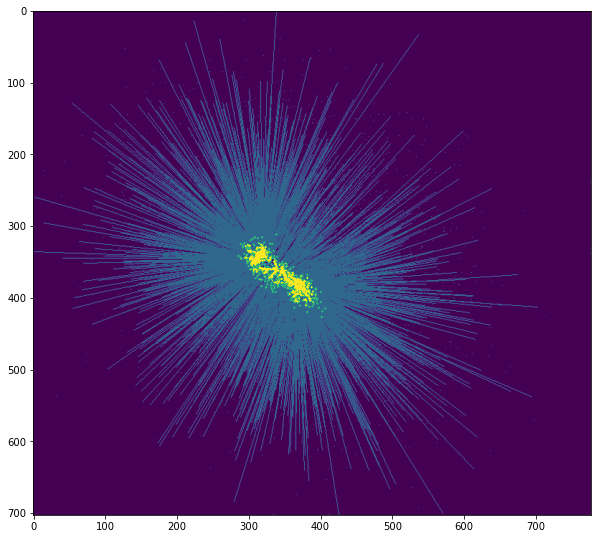


Groups: [1906, 102, 13, 6, 4, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.9464847848898216
MergedGroups: [1941, 107]
new kernelRadius : 92.51758823181355



Drawing data


<Figure size 720x720 with 0 Axes>

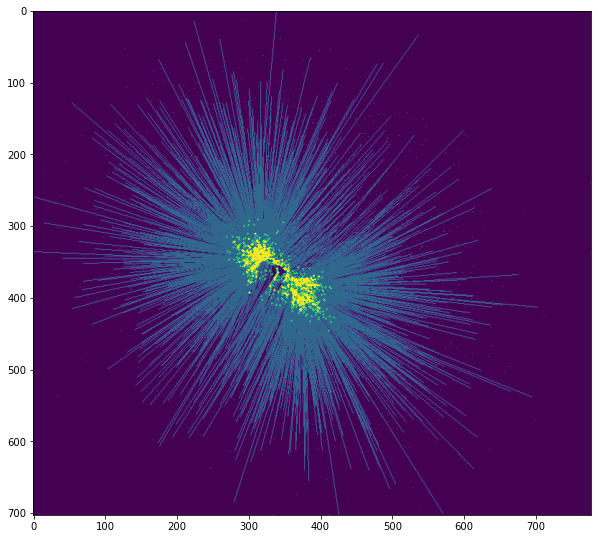


GroupsLen:  39
Groups: [1709, 165, 44, 24, 20]
Score: 0.9034523112931538
MergedGroups: [1825, 223]
new kernelRadius : 84.10689839255777



Drawing data


<Figure size 720x720 with 0 Axes>

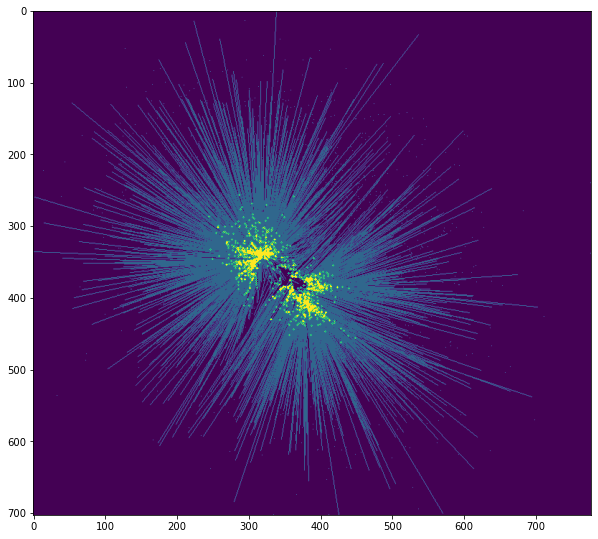


GroupsLen:  74
Groups: [720, 658, 379, 38, 30]
Score: 0.08611111111111114
MergedGroups: [853, 1195]
new kernelRadius : 76.46081672050705



Drawing data


<Figure size 720x720 with 0 Axes>

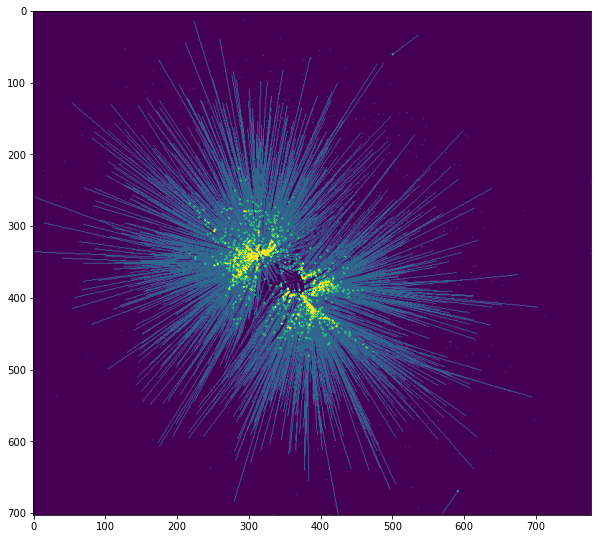


GroupsLen:  130
Groups: [860, 337, 320, 58, 44]
Score: 0.6081395348837209
MergedGroups: [1112, 936]
new kernelRadius : 69.50983338227914



Drawing data


<Figure size 720x720 with 0 Axes>

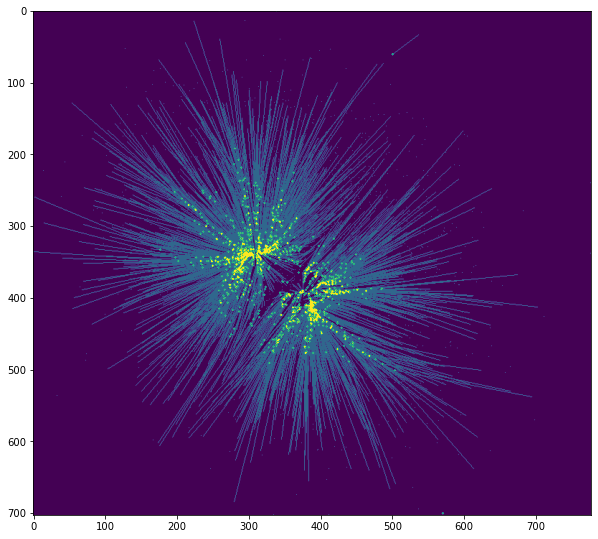


GroupsLen:  181
Groups: [658, 362, 129, 82, 59]
Score: 0.4498480243161094
MergedGroups: [1140, 908]
new kernelRadius : 63.190757620253756



Drawing data


<Figure size 720x720 with 0 Axes>

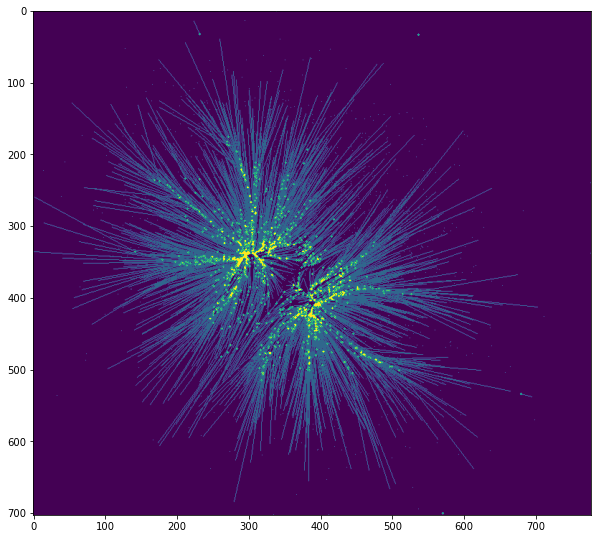


GroupsLen:  221
Groups: [423, 413, 151, 39, 38]
Score: 0.023640661938534313
MergedGroups: [1124, 924]
new kernelRadius : 57.44614329113978



Drawing data


<Figure size 720x720 with 0 Axes>

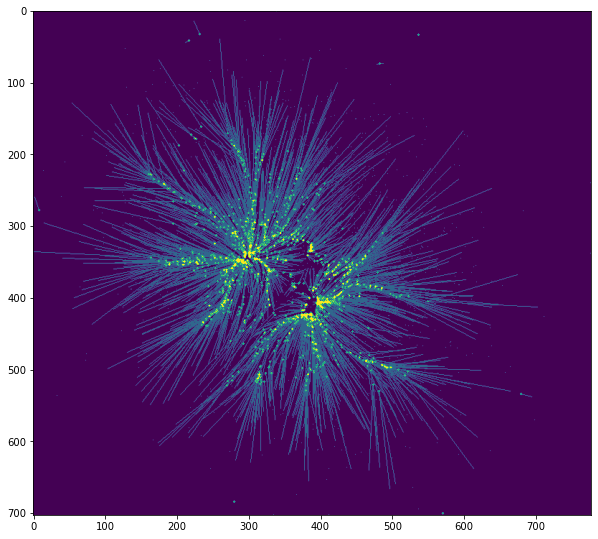


GroupsLen:  276
Groups: [384, 289, 70, 67, 62]
Score: 0.24739583333333337
MergedGroups: [1177, 871]
new kernelRadius : 52.22376662830888



Drawing data


<Figure size 720x720 with 0 Axes>

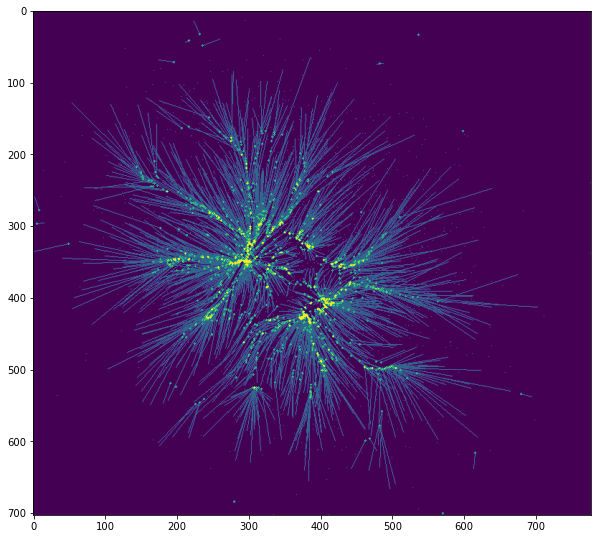


GroupsLen:  320
Groups: [198, 175, 124, 68, 58]
Score: 0.11616161616161613
MergedGroups: [1132, 916]
new kernelRadius : 47.4761514802808



Drawing data


<Figure size 720x720 with 0 Axes>

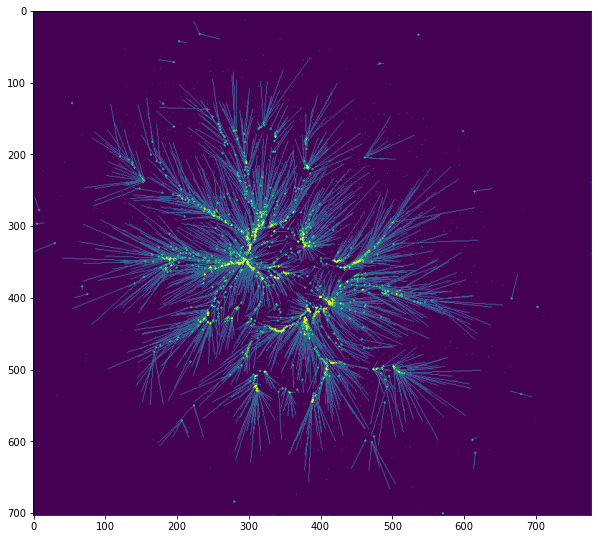


GroupsLen:  328
Groups: [150, 121, 109, 102, 101]
Score: 0.19333333333333336
MergedGroups: [843, 1205]
new kernelRadius : 43.16013770934617



Drawing data


<Figure size 720x720 with 0 Axes>

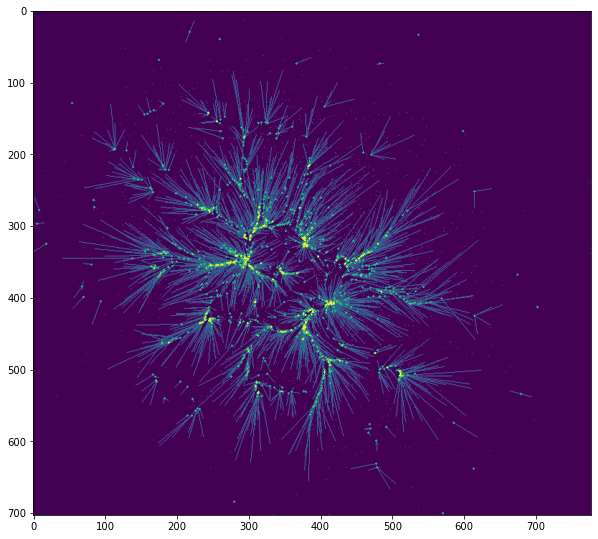


GroupsLen:  349
Groups: [165, 138, 101, 77, 68]
Score: 0.1636363636363637
MergedGroups: [1208, 840]
new kernelRadius : 39.23648882667834



Drawing data


<Figure size 720x720 with 0 Axes>

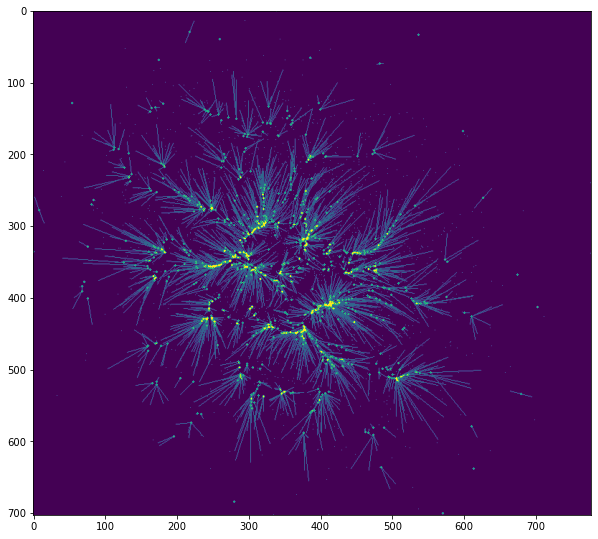


GroupsLen:  377
Groups: [134, 111, 81, 69, 63]
Score: 0.17164179104477617
MergedGroups: [811, 1237]
new kernelRadius : 35.66953529698031



Drawing data


<Figure size 720x720 with 0 Axes>

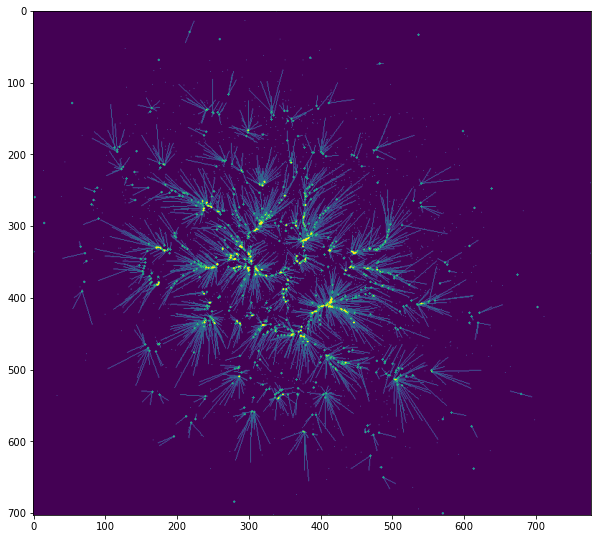


GroupsLen:  403
Groups: [131, 62, 58, 53, 45]
Score: 0.5267175572519084
MergedGroups: [925, 1123]
OldScore2 0.1636363636363637 OldScore1 0.17164179104477617 score 0.5267175572519084
2
Centroids error : [  2. -18.]
AssignedCorrectly:  1496
Missasigned:  552

Processing:  g2-2-20.txt
DataDim : 2
[0.0, 3.0, 4.47213595499958, 4.47213595499958, 4.47213595499958]
[0.0, 14.866068747318506, 15.132745950421556, 15.620499351813308, 17.4928556845359]
[0.0, 10.04987562112089, 13.0, 17.029386365926403, 17.46424919657298]
[0.0, 14.866068747318506, 15.132745950421556, 15.620499351813308, 17.4928556845359]
LeastRequired R: 14.866068747318506
kernel R: 14.866068747318506
Clustering...



Drawing data


<Figure size 720x720 with 0 Axes>

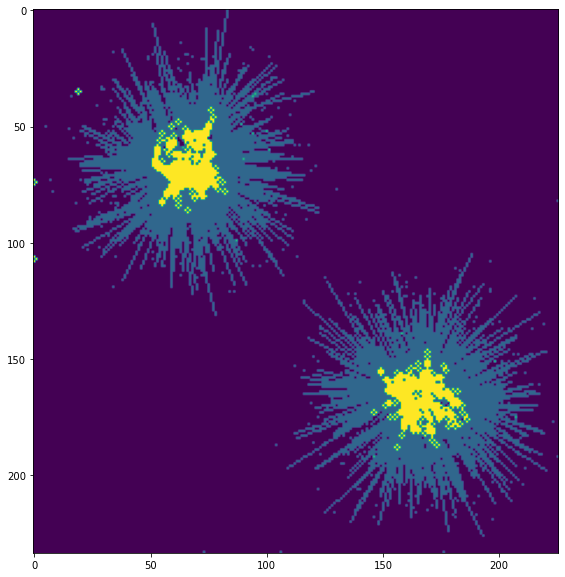


GroupsLen:  47
Groups: [893, 848, 89, 58, 26]
Score: 0.05039193729003355
MergedGroups: [1024, 1024]
2
Centroids error : [0.5 1.5]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-2-30.txt
DataDim : 2
[0.0, 2.23606797749979, 3.0, 3.605551275463989, 4.123105625617661]
[0.0, 17.08800749063506, 25.495097567963924, 28.442925306655784, 29.546573405388315]
[0.0, 21.095023109728988, 29.410882339705484, 30.528675044947494, 32.55764119219941]
[0.0, 17.08800749063506, 25.495097567963924, 28.442925306655784, 29.546573405388315]
LeastRequired R: 21.095023109728988
kernel R: 21.095023109728988
Clustering...



Drawing data


<Figure size 720x720 with 0 Axes>

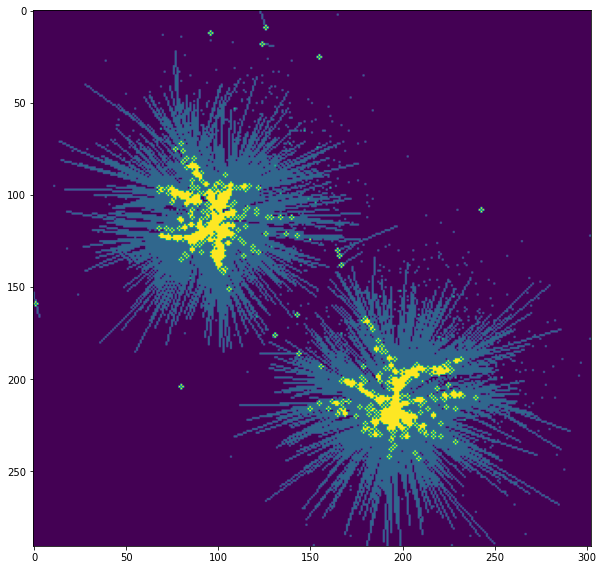


GroupsLen:  100
Groups: [698, 436, 297, 98, 48]
Score: 0.3753581661891118
MergedGroups: [1025, 1023]
2
Centroids error : [0.5 0.5]
AssignedCorrectly:  2029
Missasigned:  19

Processing:  g2-2-40.txt
DataDim : 2
[0.0, 3.605551275463989, 4.123105625617661, 4.47213595499958, 5.830951894845301]
[0.0, 16.15549442140351, 28.844410203711913, 38.01315561749642, 40.80441152620633]
[0.0, 30.463092423455635, 41.0, 46.04345773288535, 46.22769732530488]
[0.0, 16.15549442140351, 28.844410203711913, 38.01315561749642, 40.80441152620633]
LeastRequired R: 30.463092423455635
kernel R: 30.463092423455635
Clustering...



Drawing data


<Figure size 720x720 with 0 Axes>

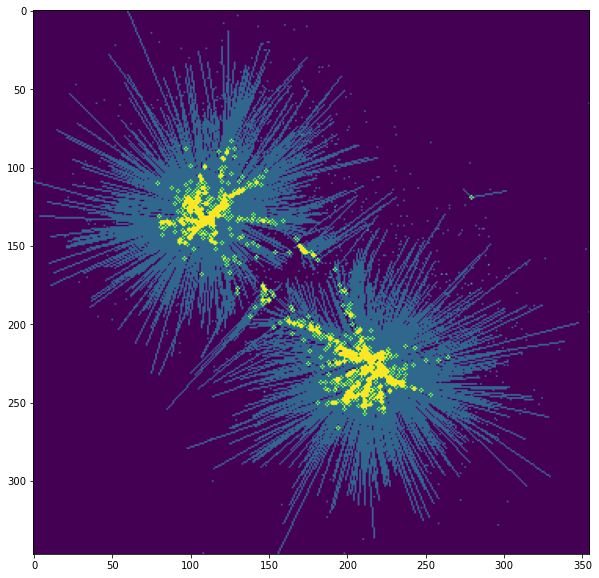


GroupsLen:  94
Groups: [787, 533, 140, 97, 67]
Score: 0.32274459974587044
MergedGroups: [1021, 1027]
2
Centroids error : [-1.5  2. ]
AssignedCorrectly:  1973
Missasigned:  75

Processing:  g2-2-50.txt
DataDim : 2
[0.0, 5.385164807134504, 11.180339887498949, 13.152946437965905, 13.416407864998739]
[0.0, 50.80354318352215, 63.60031446463138, 64.25729530566937, 69.31810730249349]
[0.0, 7.0, 12.206555615733702, 26.076809620810597, 61.05735008989499]
[0.0, 40.24922359499622, 51.62363799656123, 52.773099207835045, 53.2634959423431]
LeastRequired R: 50.80354318352215
kernel R: 50.80354318352215
Clustering...



Drawing data


<Figure size 720x720 with 0 Axes>

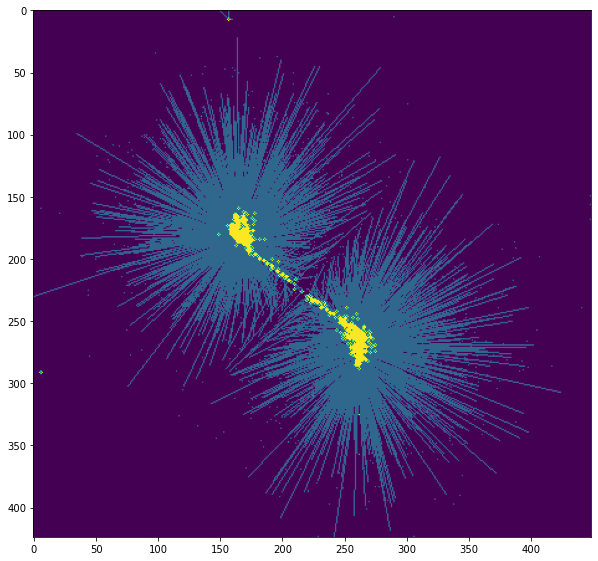


GroupsLen:  23
Groups: [982, 963, 20, 19, 15]
Score: 0.0193482688391039
MergedGroups: [1041, 1007]
2
Centroids error : [-6.5  3.5]
AssignedCorrectly:  1881
Missasigned:  167

Processing:  g2-2-60.txt
DataDim : 2
[0.0, 2.23606797749979, 5.385164807134504, 6.708203932499369, 10.04987562112089]
[0.0, 19.6468827043885, 46.09772228646444, 49.36598018878993, 51.66236541235796]
[0.0, 14.866068747318506, 47.853944456021594, 50.20956084253277, 55.71355310873648]
[0.0, 19.6468827043885, 46.09772228646444, 49.36598018878993, 51.66236541235796]
LeastRequired R: 19.6468827043885
kernel R: 19.6468827043885
Clustering...



Drawing data


<Figure size 720x720 with 0 Axes>

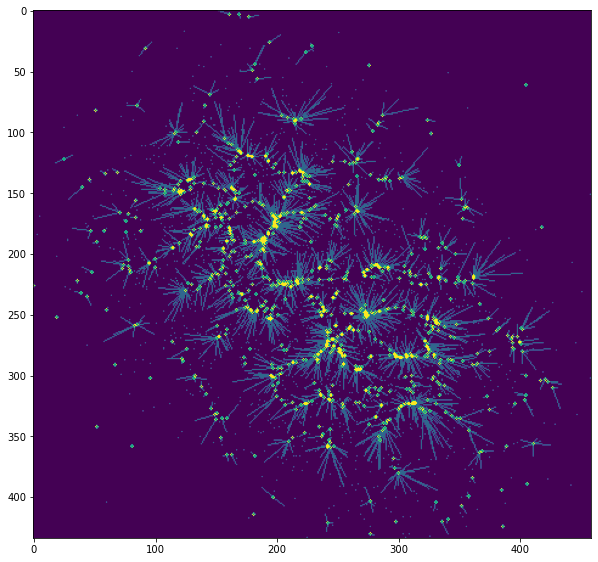


GroupsLen:  405
Groups: [87, 60, 52, 51, 42]
Score: 0.31034482758620685
MergedGroups: [1048, 1000]
new kernelRadius : 17.860802458534998



Drawing data


<Figure size 720x720 with 0 Axes>

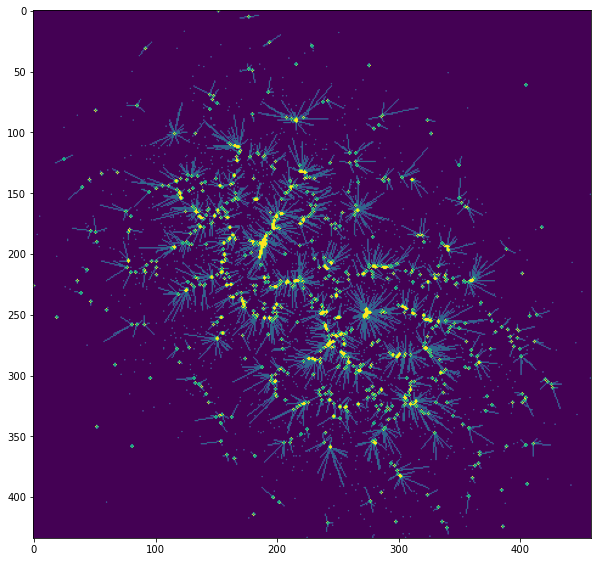


GroupsLen:  404
Groups: [85, 66, 43, 40, 38]
Score: 0.22352941176470587
MergedGroups: [1060, 988]
new kernelRadius : 16.237093144122724



Drawing data


<Figure size 720x720 with 0 Axes>

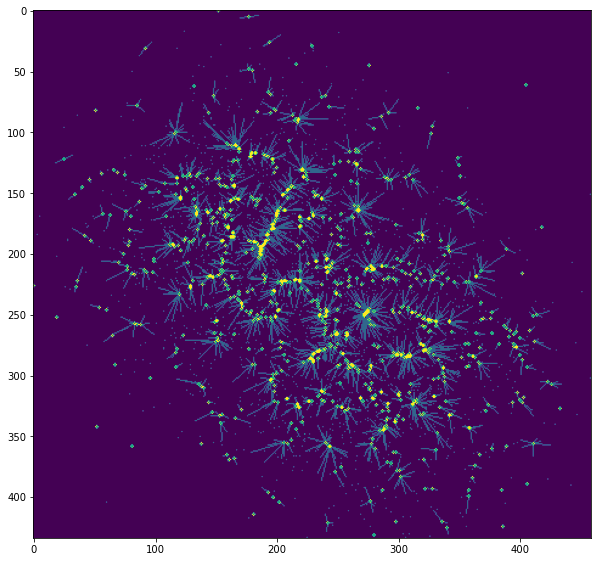


GroupsLen:  450
Groups: [75, 56, 53, 47, 38]
Score: 0.2533333333333333
MergedGroups: [1495, 553]
new kernelRadius : 14.760993767384294



Drawing data


<Figure size 720x720 with 0 Axes>

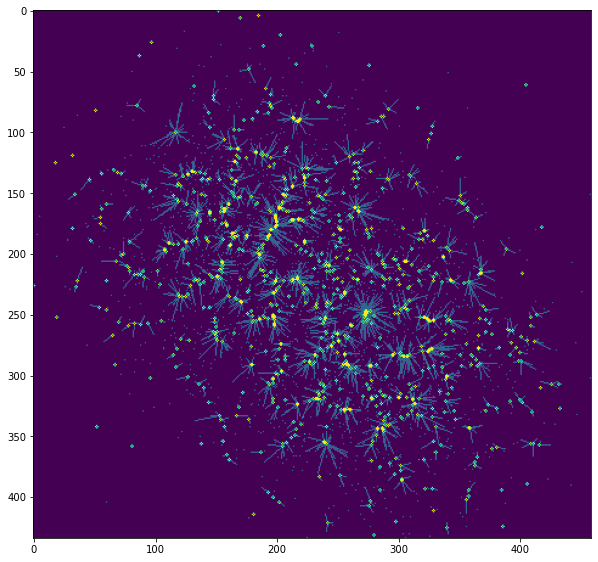


GroupsLen:  523
Groups: [70, 43, 39, 34, 33]
Score: 0.3857142857142857
MergedGroups: [1057, 991]
OldScore2 0.22352941176470587 OldScore1 0.2533333333333333 score 0.3857142857142857
2
Centroids error : [7.5 0. ]
AssignedCorrectly:  1814
Missasigned:  234

Processing:  g2-2-70.txt
DataDim : 2
[0.0, 23.08679276123039, 89.1852005660132, 90.13878188659973, 91.7877987534291]
[0.0, 58.872744118140105, 59.033888572581766, 64.00781202322104, 65.73431371817918]
[0.0, 23.08679276123039, 89.1852005660132, 90.13878188659973, 91.7877987534291]
[0.0, 58.872744118140105, 59.033888572581766, 64.00781202322104, 65.73431371817918]
LeastRequired R: 58.872744118140105
kernel R: 58.872744118140105
Clustering...



Drawing data


<Figure size 720x720 with 0 Axes>

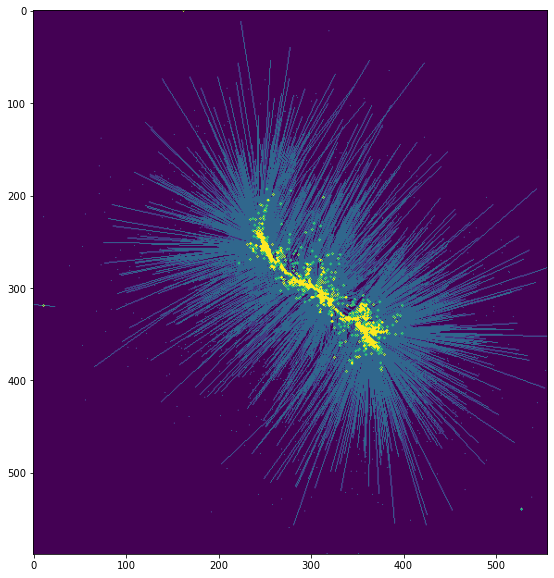


GroupsLen:  74
Groups: [1158, 472, 103, 81, 25]
Score: 0.5924006908462867
MergedGroups: [1492, 556]
new kernelRadius : 53.52067647103645



Drawing data


<Figure size 720x720 with 0 Axes>

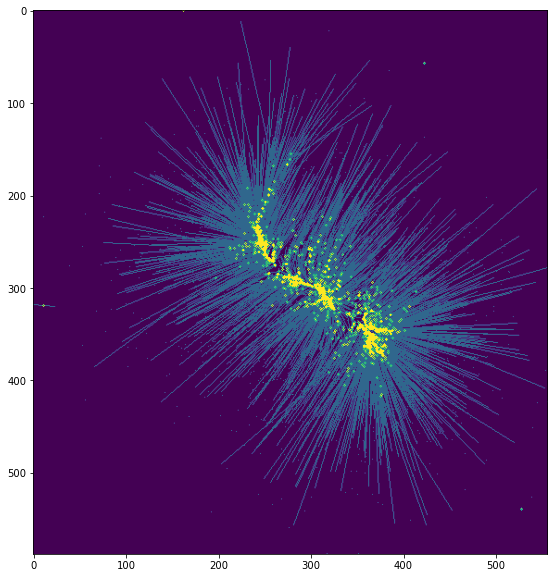


GroupsLen:  113
Groups: [592, 480, 475, 145, 21]
Score: 0.18918918918918914
MergedGroups: [725, 1323]
new kernelRadius : 48.655160428214955



Drawing data


<Figure size 720x720 with 0 Axes>

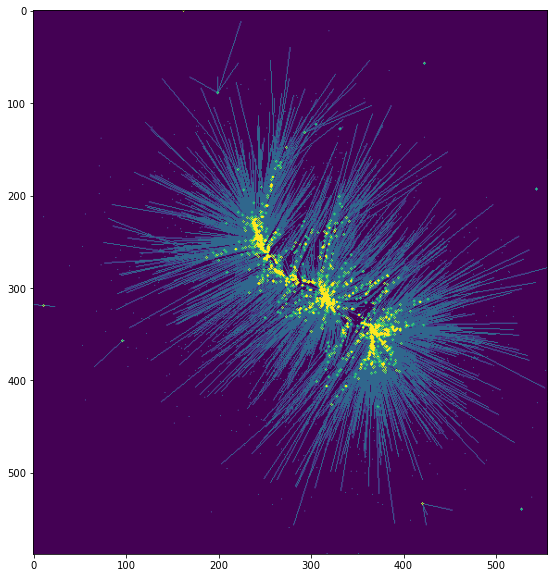


GroupsLen:  161
Groups: [493, 420, 414, 151, 33]
Score: 0.14807302231237318
MergedGroups: [1202, 846]
new kernelRadius : 44.23196402564996



Drawing data


<Figure size 720x720 with 0 Axes>

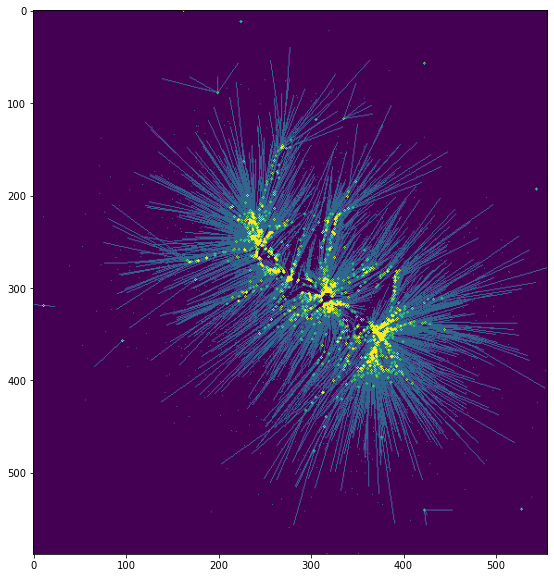


GroupsLen:  206
Groups: [394, 373, 368, 70, 66]
Score: 0.053299492385786795
MergedGroups: [1201, 847]
new kernelRadius : 40.2108763869545



Drawing data


<Figure size 720x720 with 0 Axes>

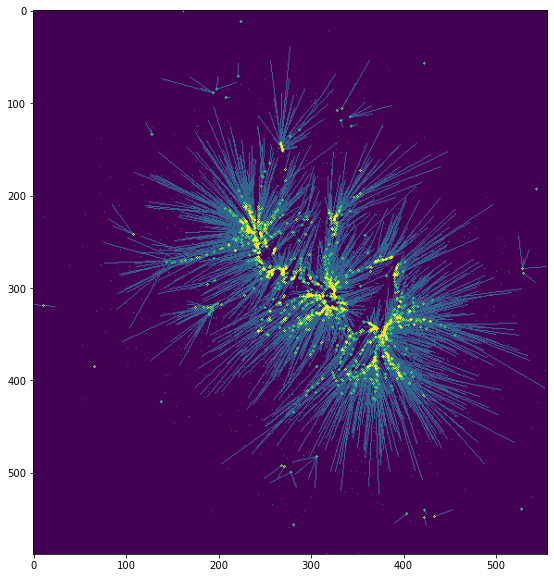


GroupsLen:  223
Groups: [275, 226, 193, 172, 133]
Score: 0.17818181818181822
MergedGroups: [1197, 851]
OldScore2 0.14807302231237318 OldScore1 0.053299492385786795 score 0.17818181818181822
2
Centroids error : [ 2.5 14.5]
AssignedCorrectly:  1719
Missasigned:  329

Processing:  g2-2-80.txt
DataDim : 2
[0.0, 3.0, 22.360679774997898, 30.870698080866262, 31.064449134018133]
[0.0, 36.796738985948195, 61.98386886924694, 66.61080993352356, 116.70903992407786]
[0.0, 9.219544457292887, 38.2099463490856, 40.80441152620633, 58.728187440104094]
[0.0, 36.796738985948195, 61.98386886924694, 66.61080993352356, 116.70903992407786]
LeastRequired R: 36.796738985948195
kernel R: 36.796738985948195
Clustering...



Drawing data


<Figure size 720x720 with 0 Axes>

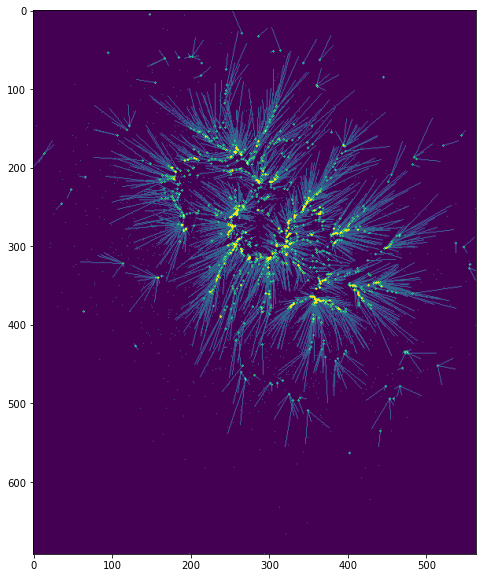


GroupsLen:  328
Groups: [138, 108, 107, 94, 91]
Score: 0.21739130434782605
MergedGroups: [1353, 695]
new kernelRadius : 33.451580896316536



Drawing data


<Figure size 720x720 with 0 Axes>

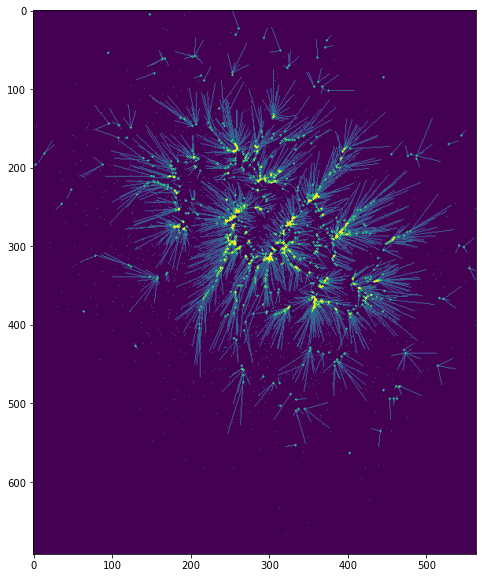


GroupsLen:  342
Groups: [93, 92, 78, 71, 66]
Score: 0.010752688172043001
MergedGroups: [934, 1114]
new kernelRadius : 30.410528087560483



Drawing data


<Figure size 720x720 with 0 Axes>

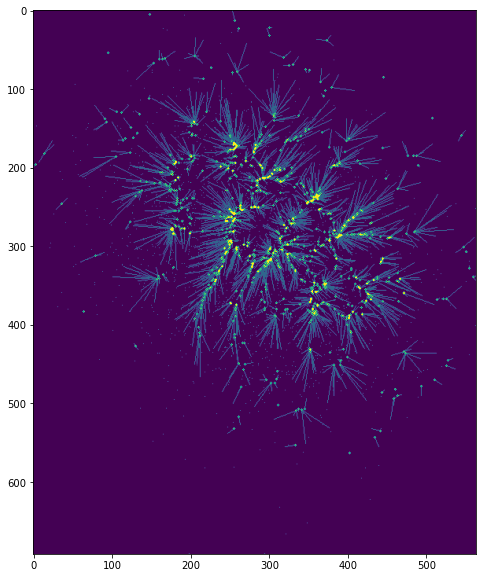


GroupsLen:  366
Groups: [76, 60, 58, 57, 49]
Score: 0.21052631578947367
MergedGroups: [928, 1120]
new kernelRadius : 27.64593462505498



Drawing data


<Figure size 720x720 with 0 Axes>

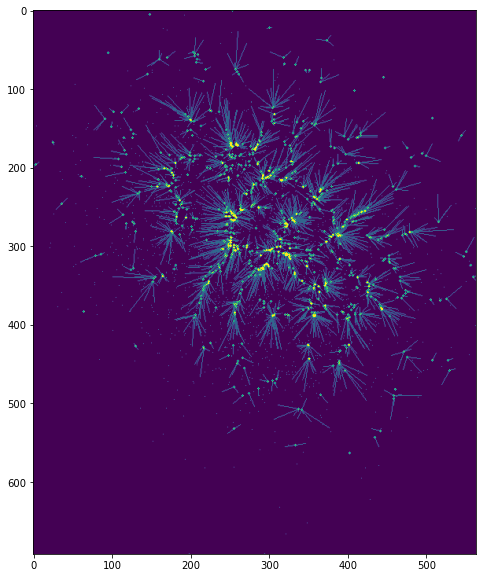


GroupsLen:  376
Groups: [72, 62, 58, 58, 52]
Score: 0.13888888888888884
MergedGroups: [973, 1075]
new kernelRadius : 25.132667840959073



Drawing data


<Figure size 720x720 with 0 Axes>

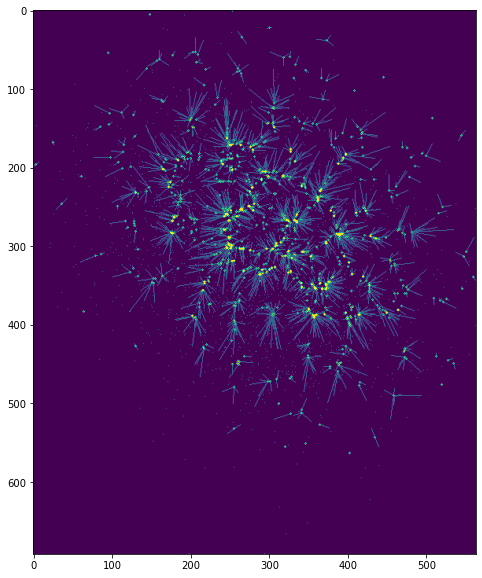


GroupsLen:  425
Groups: [56, 47, 46, 40, 40]
Score: 0.1607142857142857
MergedGroups: [1400, 648]
new kernelRadius : 22.847879855417336



Drawing data


<Figure size 720x720 with 0 Axes>

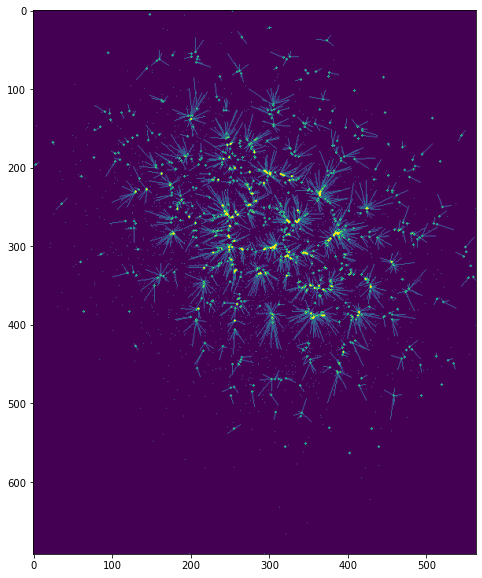


GroupsLen:  457
Groups: [57, 51, 45, 43, 42]
Score: 0.10526315789473684
MergedGroups: [1035, 1013]
2
Centroids error : [-8. 10.]
AssignedCorrectly:  1403
Missasigned:  645

Processing:  g2-2-90.txt
DataDim : 2
[0.0, 23.40939982143925, 24.186773244895647, 26.248809496813376, 55.036351623268054]
[0.0, 24.413111231467404, 55.44366510251645, 59.90826320300064, 62.177166226839255]
[0.0, 91.54780172128658, 115.12167476196652, 115.44695751729449, 116.01724009818541]
[0.0, 36.6742416417845, 38.01315561749642, 42.01190307520001, 53.150729063673246]
LeastRequired R: 91.54780172128658
kernel R: 91.54780172128658
Clustering...



Drawing data


<Figure size 720x720 with 0 Axes>

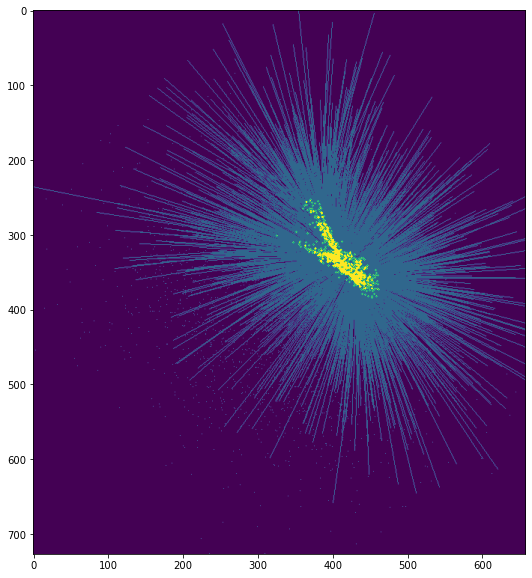


GroupsLen:  21
Groups: [1507, 239, 171, 54, 31]
Score: 0.8414067684140677
MergedGroups: [1553, 495]
new kernelRadius : 83.2252742920787



Drawing data


<Figure size 720x720 with 0 Axes>

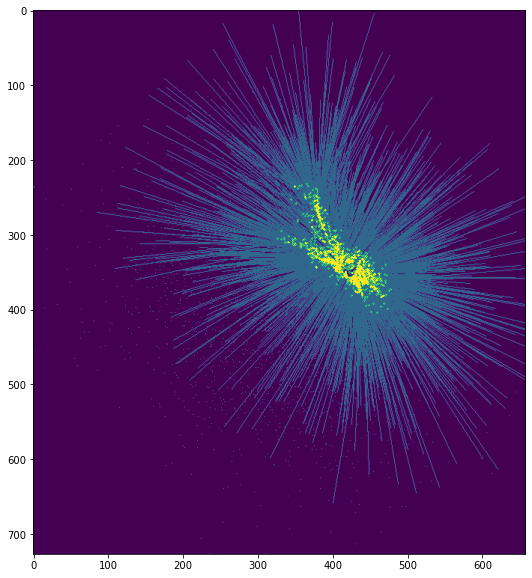


GroupsLen:  40
Groups: [1204, 419, 168, 65, 50]
Score: 0.6519933554817277
MergedGroups: [1339, 709]
new kernelRadius : 75.65934026552608



Drawing data


<Figure size 720x720 with 0 Axes>

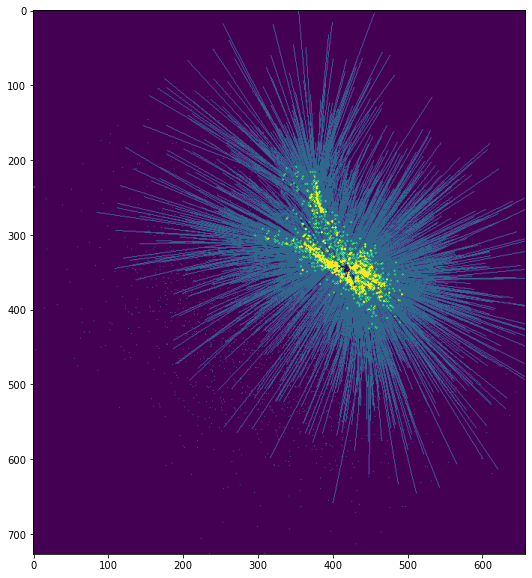


GroupsLen:  76
Groups: [1082, 384, 189, 77, 28]
Score: 0.6451016635859519
MergedGroups: [1229, 819]
new kernelRadius : 68.78121842320553



Drawing data


<Figure size 720x720 with 0 Axes>

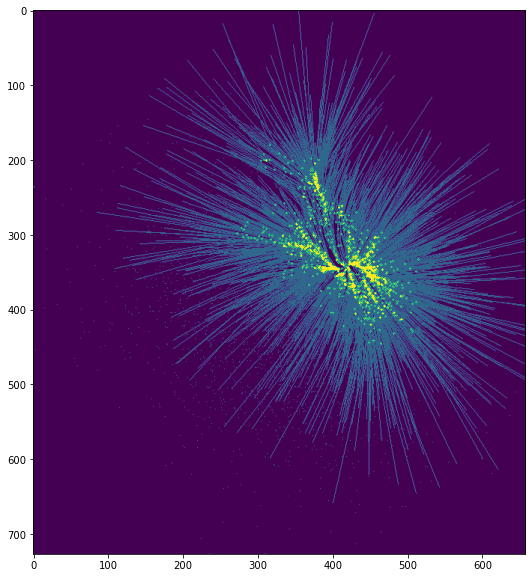


GroupsLen:  119
Groups: [986, 295, 188, 47, 30]
Score: 0.7008113590263692
MergedGroups: [1253, 795]
OldScore2 0.6519933554817277 OldScore1 0.6451016635859519 score 0.7008113590263692
2
Centroids error : [-28.  31.]
AssignedCorrectly:  1727
Missasigned:  321

Processing:  g2-256-10.txt
DataDim : 256
[0.0, 201.52171098916364, 202.10145966815776, 203.06895380633642, 203.22647465327935]
[0.0, 197.51455642559614, 199.1657601095128, 200.36466754395596, 202.2646780829515]
[0.0, 200.12745938526277, 201.83904478569056, 202.8225825691015, 202.99014754416038]
[0.0, 197.51455642559614, 199.1657601095128, 200.36466754395596, 202.2646780829515]
LeastRequired R: 201.52171098916364
kernel R: 201.52171098916364
Clustering...



GroupsLen:  609
Groups: [737, 704, 1, 1, 1]
Score: 0.04477611940298509
MergedGroups: [1024, 1024]
2
Centroids error : [0.5234375  0.49609375]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-256-100.txt
DataDim : 256
[0.0, 1953.558803824446, 1962.5340761372781, 1971.2990640691737, 1977.9464097897092]
[0.0, 2057.3774568610397, 2077.6501149134806, 2078.197295734936, 2081.049014319461]
[0.0, 2085.629641139577, 2101.3457592695213, 2102.4530910343756, 2111.563401842341]
[0.0, 2057.3774568610397, 2077.6501149134806, 2078.197295734936, 2081.049014319461]
LeastRequired R: 2085.629641139577
kernel R: 2085.629641139577
Clustering...



GroupsLen:  60
Groups: [1989, 1, 1, 1, 1]
Score: 0.9994972347913524
MergedGroups: [2047, 1]
new kernelRadius : 1896.0269464905243



GroupsLen:  1920
Groups: [67, 63, 1, 1, 1]
Score: 0.05970149253731338
MergedGroups: [1024, 1024]
2
Centroids error : [0.07421875 0.8125    ]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-256-20.txt
DataDim : 256
[0.0, 404.3587516055514, 407.6309605513301, 407.8811101289198, 408.9425387508617]
[0.0, 414.6685423323067, 416.6317318688052, 418.57257435240547, 418.7911173843113]
[0.0, 397.5260997720779, 408.0367630496056, 408.6734637825167, 409.04522977294334]
[0.0, 414.6685423323067, 416.6317318688052, 418.57257435240547, 418.7911173843113]
LeastRequired R: 414.6685423323067
kernel R: 414.6685423323067
Clustering...



GroupsLen:  119
Groups: [967, 964, 1, 1, 1]
Score: 0.0031023784901758056
MergedGroups: [1024, 1024]
2
Centroids error : [0.50390625 0.48046875]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-256-30.txt
DataDim : 256
[0.0, 556.415312513953, 572.700619870452, 580.3766018715779, 580.6418861914804]
[0.0, 639.5248235995222, 651.1988943479557, 656.4998095963166, 658.7230070371005]
[0.0, 600.5947052713668, 610.77819214507, 613.107657756776, 615.0975532385087]
[0.0, 639.5248235995222, 651.1988943479557, 656.4998095963166, 658.7230070371005]
LeastRequired R: 639.5248235995222
kernel R: 639.5248235995222
Clustering...



Groups: [1023, 1018, 1, 1, 1, 1, 1, 1, 1]
Score: 0.004887585532746819
MergedGroups: [1024, 1024]
2
Centroids error : [0.4453125  0.47265625]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-256-40.txt
DataDim : 256
[0.0, 823.797912111945, 826.8071117255826, 833.9124654302752, 834.1576589590244]
[0.0, 826.1755261444144, 827.9842993680496, 829.2972928932061, 829.3039249876971]
[0.0, 857.9370606285755, 858.8358399601171, 861.9808582561448, 862.8024107523113]
[0.0, 826.1755261444144, 827.9842993680496, 829.2972928932061, 829.3039249876971]
LeastRequired R: 857.9370606285755
kernel R: 857.9370606285755
Clustering...



Groups: [1023, 1023, 1, 1]
Score: 0.0
MergedGroups: [1024, 1024]
2
Centroids error : [0.6875 0.5   ]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-256-50.txt
DataDim : 256
[0.0, 975.3604461941237, 980.3739082615367, 984.01067067385, 987.0734521807382]
[0.0, 1040.1273960433884, 1043.3029282044597, 1043.665655274715, 1045.9655826077644]
[0.0, 1005.4516398116818, 1013.3064689421459, 1022.8924674666443, 1024.6521360930255]
[0.0, 1032.467432900428, 1034.9086916245317, 1043.2583572634346, 1045.113869394144]
LeastRequired R: 1040.1273960433884
kernel R: 1040.1273960433884
Clustering...



GroupsLen:  84
Groups: [985, 981, 1, 1, 1]
Score: 0.004060913705583702
MergedGroups: [1024, 1024]
2
Centroids error : [0.4453125 0.46875  ]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-256-60.txt
DataDim : 256
[0.0, 1201.2414411765853, 1219.8200686986586, 1240.65023274088, 1241.632393262998]
[0.0, 1229.2172305984, 1246.4718207805581, 1251.230993861645, 1264.3128568514994]
[0.0, 1240.036289791553, 1255.8475225918153, 1258.386268202256, 1265.188918699496]
[0.0, 1229.2172305984, 1246.4718207805581, 1251.230993861645, 1264.3128568514994]
LeastRequired R: 1240.036289791553
kernel R: 1240.036289791553
Clustering...



GroupsLen:  147
Groups: [957, 946, 1, 1, 1]
Score: 0.011494252873563204
MergedGroups: [1024, 1024]
2
Centroids error : [0.51953125 0.61328125]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-256-70.txt
DataDim : 256
[0.0, 1388.6965111211305, 1395.6360557108003, 1398.878479354086, 1404.3129992989454]
[0.0, 1486.3276893067693, 1507.172850073939, 1518.9371283894538, 1533.644352514624]
[0.0, 1426.2748683195675, 1439.7058727392898, 1440.462425750842, 1446.5552184413839]
[0.0, 1486.3276893067693, 1507.172850073939, 1518.9371283894538, 1533.644352514624]
LeastRequired R: 1486.3276893067693
kernel R: 1486.3276893067693
Clustering...



Groups: [1016, 1016, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.0
MergedGroups: [1024, 1024]
2
Centroids error : [0.46484375 0.30859375]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-256-80.txt
DataDim : 256
[0.0, 1551.8543746112261, 1584.9621446583512, 1593.2633178479946, 1596.8362470835887]
[0.0, 1552.0750626177846, 1571.5078746223323, 1607.112006053094, 1637.9032327949049]
[0.0, 1658.52434410834, 1659.470096145152, 1672.4508961401527, 1673.799868562547]
[0.0, 1728.2569253441457, 1731.7228415655895, 1738.6069135949047, 1743.6886189913612]
LeastRequired R: 1728.2569253441457
kernel R: 1728.2569253441457
Clustering...



Groups: [1023, 1023, 1, 1]
Score: 0.0
MergedGroups: [1024, 1024]
2
Centroids error : [0.41015625 0.50390625]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-256-90.txt
DataDim : 256
[0.0, 1863.5766686670017, 1863.7827126572454, 1868.5175942441645, 1891.6326281812755]
[0.0, 1896.0514233532804, 1897.7844977762886, 1910.6218882866385, 1916.6911592637975]
[0.0, 1794.067167081545, 1809.6190206781096, 1837.4860543688487, 1852.0437359846553]
[0.0, 1857.1179284041173, 1904.1528300007853, 1909.6675103273867, 1924.13435081857]
LeastRequired R: 1896.0514233532804
kernel R: 1896.0514233532804
Clustering...



GroupsLen:  23
Groups: [1016, 1011, 1, 1, 1]
Score: 0.004921259842519676
MergedGroups: [1024, 1024]
2
Centroids error : [0.2265625  0.39453125]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-32-10.txt
DataDim : 32
[0.0, 55.749439459065414, 61.14736298484179, 61.237243569579455, 62.153036933041335]
[0.0, 62.76941930590086, 64.67611614808051, 67.63135367564367, 67.69785816405124]
[0.0, 54.20332093147061, 54.396691075836586, 56.0357029044876, 57.7148161220323]
[0.0, 62.76941930590086, 64.67611614808051, 67.63135367564367, 67.69785816405124]
LeastRequired R: 62.76941930590086
kernel R: 62.76941930590086
Clustering...



GroupsLen:  61
Groups: [999, 990, 1, 1, 1]
Score: 0.009009009009009028
MergedGroups: [1024, 1024]
2
Centroids error : [0.59375 0.40625]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-32-100.txt
DataDim : 32
[0.0, 563.6807607147862, 571.2031162379981, 633.4335008507207, 639.7569851123159]
[0.0, 679.8529252713413, 688.9847603539573, 691.8294587541066, 692.3380677096992]
[0.0, 620.8099548170921, 636.1949386783897, 650.9900152844128, 664.0783086353597]
[0.0, 661.1769808455222, 691.0832077253795, 703.2339582244305, 708.738315600335]
LeastRequired R: 679.8529252713413
kernel R: 679.8529252713413
Clustering...



Groups: [1011, 869, 155, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.14045499505440162
MergedGroups: [1017, 1031]
2
Centroids error : [-26.125    30.90625]
AssignedCorrectly:  2037
Missasigned:  11

Processing:  g2-32-20.txt
DataDim : 32
[0.0, 113.54734695271397, 115.84903970253703, 118.42719282327012, 121.6552506059644]
[0.0, 125.03199590504823, 132.3291351139272, 135.11106542396888, 135.4289481610191]
[0.0, 107.51278993682565, 108.75201147565042, 110.82418508610834, 112.91589790636215]
[0.0, 125.03199590504823, 132.3291351139272, 135.11106542396888, 135.4289481610191]
LeastRequired R: 125.03199590504823
kernel R: 125.03199590504823
Clustering...



GroupsLen:  58
Groups: [1000, 992, 1, 1, 1]
Score: 0.008000000000000007
MergedGroups: [1024, 1024]
2
Centroids error : [0.5    0.6875]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-32-30.txt
DataDim : 32
[0.0, 168.5289292673516, 170.63118120671848, 172.5688268488837, 173.04912597294447]
[0.0, 205.83245613848172, 211.1066081391106, 221.97297132759203, 224.69089879209616]
[0.0, 190.66724941635886, 193.66982212001952, 193.79628479411053, 194.67151820438448]
[0.0, 174.29572570777518, 179.12565422071737, 180.41064270158788, 188.886209131318]
LeastRequired R: 205.83245613848172
kernel R: 205.83245613848172
Clustering...



Groups: [1024, 1022, 1, 1]
Score: 0.001953125
MergedGroups: [1024, 1024]
2
Centroids error : [0.5    0.4375]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-32-40.txt
DataDim : 32
[0.0, 194.39907407186897, 222.9910312097776, 223.26665671344657, 224.966664197165]
[0.0, 208.44903453842142, 218.4582339945098, 227.37634001804145, 234.33949731105938]
[0.0, 242.47061677654884, 245.76614901161633, 250.3237903196578, 252.10712008985388]
[0.0, 208.44903453842142, 218.4582339945098, 227.37634001804145, 234.33949731105938]
LeastRequired R: 242.47061677654884
kernel R: 242.47061677654884
Clustering...



GroupsLen:  120
Groups: [968, 962, 1, 1, 1]
Score: 0.006198347107438051
MergedGroups: [1024, 1024]
2
Centroids error : [0.21875 0.375  ]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-32-50.txt
DataDim : 32
[0.0, 265.60120481654445, 266.4469928522369, 272.5600851188596, 273.15563329354933]
[0.0, 339.50994094429694, 344.31816681668136, 344.6215315385851, 344.8419928025008]
[0.0, 367.3472471654034, 367.70640462194837, 373.9585538532312, 375.0719930893268]
[0.0, 305.2048492406371, 317.3074219113067, 317.8238505839359, 320.10467038142383]
LeastRequired R: 367.3472471654034
kernel R: 367.3472471654034
Clustering...



Groups: [1024, 1023, 1]
Score: 0.0009765625
MergedGroups: [1024, 1024]
2
Centroids error : [0.96875 0.65625]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-32-60.txt
DataDim : 32
[0.0, 314.84281792666, 318.6345869487492, 326.1625361687022, 331.7303121513016]
[0.0, 405.3689677318677, 406.5464303127012, 411.81792093108334, 411.9150397836913]
[0.0, 345.00869554259066, 382.3440858703061, 382.517973433929, 383.66261219983375]
[0.0, 397.2127893207871, 404.1138453455907, 423.26233000350976, 438.26019668685404]
LeastRequired R: 405.3689677318677
kernel R: 405.3689677318677
Clustering...



Groups: [1021, 1021, 1, 1, 1, 1, 1, 1]
Score: 0.0
MergedGroups: [1024, 1024]
2
Centroids error : [1.21875 0.3125 ]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-32-70.txt
DataDim : 32
[0.0, 407.469017227077, 410.76027071760484, 412.01820348135107, 419.89522502643445]
[0.0, 454.3919013362804, 458.8692624266742, 463.33573140866224, 464.33716198469403]
[0.0, 443.99549547264553, 449.4997219131509, 454.0495567666596, 454.62512029143306]
[0.0, 454.3919013362804, 458.8692624266742, 463.33573140866224, 464.33716198469403]
LeastRequired R: 454.3919013362804
kernel R: 454.3919013362804
Clustering...



GroupsLen:  22
Groups: [1016, 1012, 1, 1, 1]
Score: 0.003937007874015741
MergedGroups: [1024, 1024]
2
Centroids error : [0.84375 0.53125]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-32-80.txt
DataDim : 32
[0.0, 366.337276290579, 370.53339930430025, 381.7027639407396, 388.94344061829867]
[0.0, 492.5890782386471, 505.1376050147128, 535.9906715606159, 542.8535714168232]
[0.0, 440.50312144183494, 501.08182964462003, 501.08881448302157, 501.6722037346698]
[0.0, 492.5890782386471, 505.1376050147128, 535.9906715606159, 542.8535714168232]
LeastRequired R: 492.5890782386471
kernel R: 492.5890782386471
Clustering...



GroupsLen:  84
Groups: [988, 978, 1, 1, 1]
Score: 0.010121457489878583
MergedGroups: [1024, 1024]
2
Centroids error : [ 0.59375 -0.28125]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-32-90.txt
DataDim : 32
[0.0, 520.0576891076604, 529.8622462489661, 550.0027272659655, 592.7469949312269]
[0.0, 586.7009459682164, 588.2975437650578, 589.3123110881021, 593.3161046187774]
[0.0, 502.94532506028924, 611.6158925338681, 614.0513007884601, 626.2579340814773]
[0.0, 586.7009459682164, 588.2975437650578, 589.3123110881021, 593.3161046187774]
LeastRequired R: 586.7009459682164
kernel R: 586.7009459682164
Clustering...



Groups: [1019, 1016, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.0029440628066732533
MergedGroups: [1024, 1024]
2
Centroids error : [0.03125 0.9375 ]
AssignedCorrectly:  2046
Missasigned:  2

Processing:  g2-4-10.txt
DataDim : 4
[0.0, 6.244997998398398, 6.782329983125268, 8.12403840463596, 8.54400374531753]
[0.0, 13.674794331177344, 15.0996688705415, 15.427248620541512, 17.776388834631177]
[0.0, 8.246211251235321, 9.848857801796104, 12.24744871391589, 14.035668847618199]
[0.0, 13.674794331177344, 15.0996688705415, 15.427248620541512, 17.776388834631177]
LeastRequired R: 13.674794331177344
kernel R: 13.674794331177344
Clustering...



Groups: [1017, 1016, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.000983284169124854
MergedGroups: [1024, 1024]
2
Centroids error : [0.5 1. ]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-4-100.txt
DataDim : 4
[0.0, 113.68817000902072, 117.87281281109738, 126.4871534978948, 137.98188286873028]
[0.0, 127.96483892069728, 198.1665965797465, 206.3855615104894, 209.4612135933524]
[0.0, 199.32636554154095, 209.6163161588334, 213.19005605327843, 232.09480821422954]
[0.0, 165.85234396896536, 175.08569330473577, 205.34604938980442, 211.12555506143732]
LeastRequired R: 199.32636554154095
kernel R: 199.32636554154095
Clustering...



Groups: [2046, 2]
Score: 0.9990224828934506
MergedGroups: [2046, 2]
new kernelRadius : 181.20578685594631



Groups: [2044, 3, 1]
Score: 0.9985322896281801
MergedGroups: [2045, 3]
new kernelRadius : 164.73253350540574



Groups: [2001, 33, 6, 2, 2, 1, 1, 1, 1]
Score: 0.9835082458770614
MergedGroups: [2011, 37]
new kernelRadius : 149.75684864127794



Groups: [1977, 33, 12, 7, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.9833080424886191
MergedGroups: [1999, 49]
new kernelRadius : 136.14258967388903



GroupsLen:  46
Groups: [1786, 81, 48, 23, 21]
Score: 0.9546472564389697
MergedGroups: [1931, 117]
new kernelRadius : 123.76599061262638



GroupsLen:  148
Groups: [1102, 406, 141, 61, 32]
Score: 0.631578947368421
MergedGroups: [1542, 506]
new kernelRadius : 112.51453692056943



GroupsLen:  371
Groups: [578, 278, 134, 70, 51]
Score: 0.5190311418685121
MergedGroups: [1310, 738]
new kernelRadius : 102.28594265506311



GroupsLen:  648
Groups: [219, 138, 107, 83, 50]
Score: 0.36986301369863017
MergedGroups: [984, 1064]
new kernelRadius : 112.51453692056943



GroupsLen:  371
Groups: [578, 278, 134, 70, 51]
Score: 0.5190311418685121
MergedGroups: [1310, 738]
OldScore2 0.5190311418685121 OldScore1 0.36986301369863017 score 0.5190311418685121
2
Centroids error : [-10.75  16.  ]
AssignedCorrectly:  1716
Missasigned:  332

Processing:  g2-4-20.txt
DataDim : 4
[0.0, 8.246211251235321, 11.180339887498949, 12.727922061357855, 16.186414056238647]
[0.0, 14.352700094407323, 29.29163703175362, 32.90896534380867, 35.12833614050059]
[0.0, 27.748873851023216, 28.231188426986208, 31.416556144810016, 32.09361307176243]
[0.0, 22.58317958127243, 23.366642891095847, 25.337718918639855, 28.407745422683583]
LeastRequired R: 27.748873851023216
kernel R: 27.748873851023216
Clustering...



Groups: [1017, 1015, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.001966568338249708
MergedGroups: [1024, 1024]
2
Centroids error : [-0.25 -1.25]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-4-30.txt
DataDim : 4
[0.0, 17.029386365926403, 18.734993995195193, 22.781571499789035, 26.057628441590765]
[0.0, 53.48831648126533, 55.62373594069352, 57.34980383575867, 61.0163912403872]
[0.0, 20.663978319771825, 36.64696440361739, 41.0, 44.339598554790726]
[0.0, 53.48831648126533, 55.62373594069352, 57.34980383575867, 61.0163912403872]
LeastRequired R: 53.48831648126533
kernel R: 53.48831648126533
Clustering...



Groups: [1024, 1021, 1, 1, 1]
Score: 0.0029296875
MergedGroups: [1025, 1023]
2
Centroids error : [0.   0.75]
AssignedCorrectly:  2047
Missasigned:  1

Processing:  g2-4-40.txt
DataDim : 4
[0.0, 20.346989949375804, 23.748684174075834, 23.874672772626646, 28.106938645110393]
[0.0, 83.78544026261365, 86.20324819866129, 91.45490692138941, 92.89779329994873]
[0.0, 36.41428291206625, 38.535697735995385, 57.810033731178535, 58.01723881744115]
[0.0, 83.78544026261365, 86.20324819866129, 91.45490692138941, 92.89779329994873]
LeastRequired R: 83.78544026261365
kernel R: 83.78544026261365
Clustering...



Groups: [1025, 1022, 1]
Score: 0.0029268292682926855
MergedGroups: [1025, 1023]
2
Centroids error : [0.75 0.  ]
AssignedCorrectly:  2035
Missasigned:  13

Processing:  g2-4-50.txt
DataDim : 4
[0.0, 13.30413469565007, 13.416407864998739, 17.74823934929885, 23.958297101421877]
[0.0, 77.12327793863537, 78.13449942247023, 78.49840762716146, 79.88742078700501]
[0.0, 73.91210996852952, 76.1774244773345, 79.71825386948713, 81.01234473831751]
[0.0, 77.12327793863537, 78.13449942247023, 78.49840762716146, 79.88742078700501]
LeastRequired R: 77.12327793863537
kernel R: 77.12327793863537
Clustering...



Groups: [1027, 1006, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.020447906523855863
MergedGroups: [1031, 1017]
2
Centroids error : [-1.25  0.  ]
AssignedCorrectly:  1997
Missasigned:  51

Processing:  g2-4-60.txt
DataDim : 4
[0.0, 25.495097567963924, 30.23243291566195, 31.937438845342623, 32.357379374726875]
[0.0, 90.9450383473447, 124.27389106324787, 152.50901612691624, 156.81836627130127]
[0.0, 47.51841748206689, 72.60165287374662, 85.65628990331066, 89.27485648266257]
[0.0, 90.9450383473447, 124.27389106324787, 152.50901612691624, 156.81836627130127]
LeastRequired R: 90.9450383473447
kernel R: 90.9450383473447
Clustering...



Groups: [1014, 995, 12, 7, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.018737672583826415
MergedGroups: [1040, 1008]
2
Centroids error : [-5.5  10.25]
AssignedCorrectly:  1962
Missasigned:  86

Processing:  g2-4-70.txt
DataDim : 4
[0.0, 33.090784215548595, 39.42080668885405, 39.496835316262995, 41.48493702538308]
[0.0, 184.1032319107951, 190.2866259094422, 194.83326204732086, 205.7644284126875]
[0.0, 64.6297145282261, 74.93330367733695, 80.90735442467513, 81.08020720249795]
[0.0, 184.1032319107951, 190.2866259094422, 194.83326204732086, 205.7644284126875]
LeastRequired R: 184.1032319107951
kernel R: 184.1032319107951
Clustering...



Groups: [2048]
Score: 1.0
MergedGroups: [2048]
new kernelRadius : 167.36657446435916



Groups: [2033, 14, 1]
Score: 0.9931136251844564
MergedGroups: [2034, 14]
new kernelRadius : 152.15143133123559



Groups: [1998, 37, 8, 2, 1, 1, 1]
Score: 0.9814814814814815
MergedGroups: [2010, 38]
new kernelRadius : 138.31948302839598



Groups: [1491, 518, 28, 4, 3, 2, 1, 1]
Score: 0.6525821596244131
MergedGroups: [1527, 521]
new kernelRadius : 125.74498457126906



Groups: [1000, 995, 42, 8, 1, 1, 1]
Score: 0.0050000000000000044
MergedGroups: [1044, 1004]
new kernelRadius : 114.31362233751732



Groups: [979, 953, 78, 10, 9, 6, 5, 3, 3, 1, 1]
Score: 0.026557711950970342
MergedGroups: [1003, 1045]
new kernelRadius : 103.92147485228845



GroupsLen:  25
Groups: [966, 877, 131, 25, 8]
Score: 0.09213250517598348
MergedGroups: [1000, 1048]
OldScore2 0.0050000000000000044 OldScore1 0.026557711950970342 score 0.09213250517598348
2
Centroids error : [-14.5   13.75]
AssignedCorrectly:  1890
Missasigned:  158

Processing:  g2-4-80.txt
DataDim : 4
[0.0, 46.09772228646444, 47.7179211617606, 48.05205510693585, 48.093658625644196]
[0.0, 169.9117417955569, 174.16658692183182, 183.49114420047633, 183.86679961319825]
[0.0, 98.37682653958706, 116.26693425045661, 150.90394295710104, 166.01505955786058]
[0.0, 169.9117417955569, 174.16658692183182, 183.49114420047633, 183.86679961319825]
LeastRequired R: 169.9117417955569
kernel R: 169.9117417955569
Clustering...



Groups: [2028, 16, 3, 1]
Score: 0.9921104536489151
MergedGroups: [2028, 20]
new kernelRadius : 154.46521981414264



Groups: [1974, 48, 17, 5, 3, 1]
Score: 0.9756838905775076
MergedGroups: [1977, 71]
new kernelRadius : 140.42292710376603



Groups: [1491, 486, 60, 5, 2, 1, 1, 1, 1]
Score: 0.6740442655935613
MergedGroups: [1499, 549]
new kernelRadius : 127.65720645796911



Groups: [990, 901, 120, 10, 6, 5, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.08989898989898992
MergedGroups: [1002, 1046]
new kernelRadius : 116.052005870881



GroupsLen:  38
Groups: [983, 947, 20, 12, 12]
Score: 0.03662258392675488
MergedGroups: [1030, 1018]
2
Centroids error : [-10.5  14. ]
AssignedCorrectly:  1840
Missasigned:  208

Processing:  g2-4-90.txt
DataDim : 4
[0.0, 32.57299494980466, 63.047601064592456, 67.55738301621814, 69.67065379340143]
[0.0, 94.67312184564318, 114.9434643640081, 120.16655108639841, 126.21014222319853]
[0.0, 126.09916732476864, 129.3599628942433, 141.04254677224174, 144.24631711069785]
[0.0, 94.67312184564318, 114.9434643640081, 120.16655108639841, 126.21014222319853]
LeastRequired R: 126.09916732476864
kernel R: 126.09916732476864
Clustering...



GroupsLen:  47
Groups: [1037, 793, 74, 32, 13]
Score: 0.23529411764705888
MergedGroups: [1176, 872]
new kernelRadius : 114.63560665888058



GroupsLen:  124
Groups: [794, 783, 122, 49, 27]
Score: 0.013853904282115859
MergedGroups: [937, 1111]
new kernelRadius : 104.21418787170961



GroupsLen:  268
Groups: [502, 367, 180, 174, 81]
Score: 0.2689243027888446
MergedGroups: [992, 1056]
OldScore2 0.23529411764705888 OldScore1 0.013853904282115859 score 0.2689243027888446
2
Centroids error : [-9.75  5.25]
AssignedCorrectly:  1751
Missasigned:  297

Processing:  g2-512-10.txt
DataDim : 512
[0.0, 287.56912212544654, 288.5359596306845, 288.5810111563129, 290.3050120132272]
[0.0, 309.99193537897077, 310.2289477144259, 310.4174608490959, 311.2089330337418]
[0.0, 305.66648491452247, 307.99837661909845, 308.3520715026899, 308.3893642783421]
[0.0, 309.99193537897077, 310.2289477144259, 310.4174608490959, 311.2089330337418]
LeastRequired R: 309.99193537897077
kernel R: 309.99193537897077
Clustering...



Groups: [1024, 1023, 1]
Score: 0.0009765625
MergedGroups: [1024, 1024]
2
Centroids error : [0.49804688 0.44921875]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-512-100.txt
DataDim : 512
[0.0, 2859.913460229173, 2878.660278671313, 2884.538091272154, 2887.089711110481]
[0.0, 2990.1953113467353, 3033.2952378560185, 3042.120641920698, 3047.6507345822947]
[0.0, 3023.8860758963788, 3068.842452782482, 3095.5647303844253, 3103.5151038781814]
[0.0, 2905.3041148905563, 2950.594177449688, 2956.1429261793146, 2968.5289286109373]
LeastRequired R: 3023.8860758963788
kernel R: 3023.8860758963788
Clustering...



GroupsLen:  66
Groups: [1983, 1, 1, 1, 1]
Score: 0.9994957135653051
MergedGroups: [2047, 1]
new kernelRadius : 2748.9873417239805



GroupsLen:  2047
Groups: [2, 1, 1, 1, 1]
Score: 0.5
MergedGroups: [1845, 203]
new kernelRadius : 3023.8860758963788



GroupsLen:  66
Groups: [1983, 1, 1, 1, 1]
Score: 0.9994957135653051
MergedGroups: [2047, 1]
OldScore2 0.9994957135653051 OldScore1 0.5 score 0.9994957135653051
2
Centroids error : [-43.59765625  -3.37304688]
AssignedCorrectly:  1227
Missasigned:  821

Processing:  g2-512-20.txt
DataDim : 512
[0.0, 595.2570873160604, 598.1630212575833, 600.0216662754771, 601.0998253202208]
[0.0, 596.0713044594581, 598.2674986993694, 600.8144472297582, 608.3650220057034]
[0.0, 600.0841607641381, 604.0637383587928, 604.7131551405179, 607.4397089423773]
[0.0, 598.6877316264298, 601.1139658999781, 604.096846540354, 604.848741422184]
LeastRequired R: 600.0841607641381
kernel R: 600.0841607641381
Clustering...



GroupsLen:  176
Groups: [938, 936, 1, 1, 1]
Score: 0.002132196162046962
MergedGroups: [1024, 1024]
2
Centroids error : [0.48828125 0.47070312]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-512-30.txt
DataDim : 512
[0.0, 871.0051664599929, 885.6438336035542, 889.1248506256026, 894.2784801167923]
[0.0, 908.9196884213699, 909.5878187398949, 920.9723122873999, 923.9442623881595]
[0.0, 884.8937789362066, 886.1331728357765, 886.5150872940629, 886.8624470570394]
[0.0, 908.9196884213699, 909.5878187398949, 920.9723122873999, 923.9442623881595]
LeastRequired R: 908.9196884213699
kernel R: 908.9196884213699
Clustering...



GroupsLen:  56
Groups: [998, 996, 1, 1, 1]
Score: 0.002004008016032066
MergedGroups: [1024, 1024]
2
Centroids error : [0.41210938 0.50585938]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-512-40.txt
DataDim : 512
[0.0, 1166.5641859752081, 1167.6480634163704, 1176.771430652529, 1178.5117733820057]
[0.0, 1180.900503852886, 1181.516821716898, 1186.9136447105157, 1187.4893683734604]
[0.0, 1201.1448705297792, 1205.8399562130955, 1213.6473952511908, 1215.4024024988596]
[0.0, 1180.900503852886, 1181.516821716898, 1186.9136447105157, 1187.4893683734604]
LeastRequired R: 1201.1448705297792
kernel R: 1201.1448705297792
Clustering...



GroupsLen:  128
Groups: [968, 954, 1, 1, 1]
Score: 0.01446280991735538
MergedGroups: [1024, 1024]
2
Centroids error : [0.63671875 0.47265625]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-512-50.txt
DataDim : 512
[0.0, 1504.297510467926, 1511.3159828440907, 1512.6585867273554, 1514.4867117277722]
[0.0, 1442.0818284688287, 1473.6091747814276, 1477.0111712509151, 1479.4133972625773]
[0.0, 1481.5289399805863, 1483.2174486568044, 1485.2393746463902, 1518.150519546728]
[0.0, 1454.801017321613, 1467.6317658050332, 1487.81047180076, 1493.2113045379747]
LeastRequired R: 1504.297510467926
kernel R: 1504.297510467926
Clustering...



GroupsLen:  118
Groups: [977, 955, 1, 1, 1]
Score: 0.022517911975434957
MergedGroups: [1024, 1024]
2
Centroids error : [0.484375   0.54296875]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-512-60.txt
DataDim : 512
[0.0, 1752.6343029850807, 1760.207942261368, 1760.316448823904, 1765.694480933777]
[0.0, 1792.4449782350364, 1799.3990663552097, 1799.4893720164062, 1804.6390220761602]
[0.0, 1784.0400780251546, 1814.2938020067202, 1822.3498566411445, 1824.6575021082724]
[0.0, 1791.2303034506758, 1796.3616005693286, 1798.1014988036688, 1816.3119225507496]
LeastRequired R: 1792.4449782350364
kernel R: 1792.4449782350364
Clustering...



GroupsLen:  199
Groups: [927, 924, 1, 1, 1]
Score: 0.003236245954692518
MergedGroups: [1024, 1024]
2
Centroids error : [0.45703125 0.3046875 ]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-512-70.txt
DataDim : 512
[0.0, 2061.6105354794827, 2067.392076989752, 2072.13633721336, 2073.691153474885]
[0.0, 2144.5883054796323, 2171.5109946762877, 2173.6004692675237, 2176.6046953914256]
[0.0, 2081.7322114047233, 2115.943761067387, 2130.2239318907295, 2132.6204538079437]
[0.0, 2144.5883054796323, 2171.5109946762877, 2173.6004692675237, 2176.6046953914256]
LeastRequired R: 2144.5883054796323
kernel R: 2144.5883054796323
Clustering...



Groups: [1019, 1018, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.0009813542688911214
MergedGroups: [1024, 1024]
2
Centroids error : [0.43359375 0.59765625]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-512-80.txt
DataDim : 512
[0.0, 2319.857969790392, 2325.5311221310285, 2326.2704056063644, 2330.569029228699]
[0.0, 2464.36847894141, 2484.5504623573256, 2484.716482820525, 2497.4340832142097]
[0.0, 2422.157302901692, 2428.239691628485, 2445.2830102055673, 2453.90810748895]
[0.0, 2464.36847894141, 2484.5504623573256, 2484.716482820525, 2497.4340832142097]
LeastRequired R: 2464.36847894141
kernel R: 2464.36847894141
Clustering...



Groups: [1023, 1020, 1, 1, 1, 1, 1]
Score: 0.0029325513196480912
MergedGroups: [1024, 1024]
2
Centroids error : [0.4453125  0.28515625]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-512-90.txt
DataDim : 512
[0.0, 2625.600693174802, 2689.854828796528, 2714.992265182352, 2728.012096747373]
[0.0, 2699.310282275826, 2707.773624216027, 2713.3527231084427, 2717.265353254996]
[0.0, 2767.638162766224, 2788.7543814398573, 2793.258312437287, 2793.805827182698]
[0.0, 2580.2352605915607, 2604.705357617249, 2671.3960769605096, 2690.6989798191844]
LeastRequired R: 2767.638162766224
kernel R: 2767.638162766224
Clustering...



Groups: [1021, 1018, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.002938295788442735
MergedGroups: [1024, 1024]
2
Centroids error : [0.68554688 0.5234375 ]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-64-10.txt
DataDim : 64
[0.0, 86.39444426582071, 89.97777503361594, 91.10982383914481, 93.69098142297368]
[0.0, 86.18004409374598, 87.7040477971228, 88.18163074019441, 88.31760866327846]
[0.0, 94.83142938920619, 94.8525170989152, 95.69743988216194, 96.27564593395361]
[0.0, 86.18004409374598, 87.7040477971228, 88.18163074019441, 88.31760866327846]
LeastRequired R: 94.83142938920619
kernel R: 94.83142938920619
Clustering...



GroupsLen:  60
Groups: [997, 993, 1, 1, 1]
Score: 0.004012036108325012
MergedGroups: [1024, 1024]
2
Centroids error : [0.546875 0.46875 ]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-64-100.txt
DataDim : 64
[0.0, 884.2590118285478, 893.0957395486779, 905.394389202849, 922.8791903602552]
[0.0, 1046.0258123010158, 1065.913223484914, 1067.6319590570527, 1074.1955129304906]
[0.0, 935.344321627068, 1000.4289080189557, 1021.5033039594146, 1024.8838958633314]
[0.0, 1046.0258123010158, 1065.913223484914, 1067.6319590570527, 1074.1955129304906]
LeastRequired R: 1046.0258123010158
kernel R: 1046.0258123010158
Clustering...



Groups: [2043, 1, 1, 1, 1, 1]
Score: 0.9995105237395986
MergedGroups: [2047, 1]
new kernelRadius : 950.932556637287



GroupsLen:  67
Groups: [997, 986, 1, 1, 1]
Score: 0.011033099297893645
MergedGroups: [1024, 1024]
2
Centroids error : [-1.15625  1.65625]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-64-20.txt
DataDim : 64
[0.0, 166.4932431061393, 170.71028088548152, 174.82276739601167, 174.8799588289064]
[0.0, 193.90203712184152, 200.13995103427, 200.51184503664615, 200.98009851724126]
[0.0, 194.3707796969493, 199.93749023132204, 202.37588789181382, 202.37835852679504]
[0.0, 193.90203712184152, 200.13995103427, 200.51184503664615, 200.98009851724126]
LeastRequired R: 194.3707796969493
kernel R: 194.3707796969493
Clustering...



GroupsLen:  33
Groups: [1012, 1005, 1, 1, 1]
Score: 0.00691699604743079
MergedGroups: [1024, 1024]
2
Centroids error : [0.515625 0.546875]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-64-30.txt
DataDim : 64
[0.0, 268.43434951585465, 268.6875508839217, 269.5867207412116, 270.5494409530354]
[0.0, 291.0755915565577, 297.9714751448534, 299.0217383402083, 310.9163874741889]
[0.0, 257.0933682536366, 272.268250077015, 274.534150881088, 275.50136115816196]
[0.0, 283.7780823108085, 290.00517236766655, 299.02675465583343, 299.44448567305426]
LeastRequired R: 291.0755915565577
kernel R: 291.0755915565577
Clustering...



GroupsLen:  44
Groups: [1006, 1000, 1, 1, 1]
Score: 0.005964214711729587
MergedGroups: [1024, 1024]
2
Centroids error : [0.40625 0.59375]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-64-40.txt
DataDim : 64
[0.0, 355.08590509903377, 355.2154275928905, 361.23122788596226, 363.1652516417285]
[0.0, 382.8576759058123, 382.9804172539374, 388.4366100150705, 394.12561449365353]
[0.0, 386.1152677633973, 408.2193038061772, 408.3833982913605, 412.751741365194]
[0.0, 382.8576759058123, 382.9804172539374, 388.4366100150705, 394.12561449365353]
LeastRequired R: 386.1152677633973
kernel R: 386.1152677633973
Clustering...



GroupsLen:  46
Groups: [1004, 1000, 1, 1, 1]
Score: 0.003984063745019917
MergedGroups: [1024, 1024]
2
Centroids error : [0.546875 0.421875]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-64-50.txt
DataDim : 64
[0.0, 450.9911307331886, 458.30557491699795, 472.259462583864, 472.27746082149633]
[0.0, 566.9797174502805, 568.7345602299899, 572.8324362324466, 574.8869454075297]
[0.0, 485.976336872486, 486.8192683121735, 499.50475473212464, 506.0622491354201]
[0.0, 566.9797174502805, 568.7345602299899, 572.8324362324466, 574.8869454075297]
LeastRequired R: 566.9797174502805
kernel R: 566.9797174502805
Clustering...



Groups: [1024, 1023, 1]
Score: 0.0009765625
MergedGroups: [1024, 1024]
2
Centroids error : [0.4375   0.234375]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-64-60.txt
DataDim : 64
[0.0, 475.3998317206265, 499.17331659454715, 511.0919682405506, 513.6895949890362]
[0.0, 562.620653726825, 571.6948486736609, 576.3948299559946, 584.9675204658802]
[0.0, 570.738994637654, 579.8861957315418, 580.3421404654326, 581.2185475361226]
[0.0, 562.620653726825, 571.6948486736609, 576.3948299559946, 584.9675204658802]
LeastRequired R: 570.738994637654
kernel R: 570.738994637654
Clustering...



GroupsLen:  83
Groups: [987, 980, 1, 1, 1]
Score: 0.007092198581560294
MergedGroups: [1024, 1024]
2
Centroids error : [0.734375 0.25    ]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-64-70.txt
DataDim : 64
[0.0, 668.9446912862079, 670.7428717474379, 673.774442970346, 674.0756634087898]
[0.0, 641.9088720371452, 668.7054658068827, 687.0101891529703, 690.0304341114238]
[0.0, 668.9446912862079, 670.7428717474379, 673.774442970346, 674.0756634087898]
[0.0, 641.9088720371452, 668.7054658068827, 687.0101891529703, 690.0304341114238]
LeastRequired R: 668.9446912862079
kernel R: 668.9446912862079
Clustering...



GroupsLen:  75
Groups: [991, 984, 1, 1, 1]
Score: 0.007063572149344055
MergedGroups: [1024, 1024]
2
Centroids error : [0.375   0.59375]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-64-80.txt
DataDim : 64
[0.0, 649.8207445134389, 653.2235451972012, 658.6736673042274, 668.7682707784513]
[0.0, 746.2251670910061, 749.5011674440541, 753.9336840863392, 762.2145367283414]
[0.0, 739.7776693034199, 747.5252504096434, 749.7933048514103, 754.8344189290788]
[0.0, 747.545316352126, 765.9986945158588, 767.9628897284035, 777.2168294626667]
LeastRequired R: 747.545316352126
kernel R: 747.545316352126
Clustering...



GroupsLen:  143
Groups: [959, 948, 1, 1, 1]
Score: 0.01147028154327423
MergedGroups: [1024, 1024]
2
Centroids error : [0.515625 0.046875]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-64-90.txt
DataDim : 64
[0.0, 789.061467821107, 821.4846316273969, 832.4758254748302, 847.5334801646482]
[0.0, 807.5809556942263, 809.1891002726124, 874.7708271313121, 877.1356793563924]
[0.0, 869.0155349589558, 897.3516590501184, 899.1940836104294, 903.8810762484188]
[0.0, 807.5809556942263, 809.1891002726124, 874.7708271313121, 877.1356793563924]
LeastRequired R: 869.0155349589558
kernel R: 869.0155349589558
Clustering...



GroupsLen:  47
Groups: [1004, 999, 1, 1, 1]
Score: 0.004980079681274896
MergedGroups: [1024, 1024]
2
Centroids error : [-0.46875   0.328125]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-8-10.txt
DataDim : 8
[0.0, 10.295630140987, 11.445523142259598, 12.649110640673518, 13.564659966250536]
[0.0, 20.566963801203133, 23.83275057562597, 23.93741840717165, 24.596747752497688]
[0.0, 14.212670403551895, 18.24828759089466, 18.76166303929372, 19.4164878389476]
[0.0, 20.566963801203133, 23.83275057562597, 23.93741840717165, 24.596747752497688]
LeastRequired R: 20.566963801203133
kernel R: 20.566963801203133
Clustering...



GroupsLen:  103
Groups: [972, 971, 2, 2, 2]
Score: 0.0010288065843621075
MergedGroups: [1024, 1024]
2
Centroids error : [1.   0.25]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-8-100.txt
DataDim : 8
[0.0, 187.98936140111758, 196.98984745412642, 204.50183373260984, 206.2619693496598]
[0.0, 301.03322075810837, 302.0728388981704, 306.2433672751134, 339.05899191733585]
[0.0, 246.07925552553186, 269.33622110663094, 277.0469274328809, 284.71389147704053]
[0.0, 253.24888943487986, 267.4116676586869, 267.70879701645964, 288.1909089475239]
LeastRequired R: 301.03322075810837
kernel R: 301.03322075810837
Clustering...



Groups: [2028, 18, 1, 1]
Score: 0.9911242603550295
MergedGroups: [2029, 19]
new kernelRadius : 273.66656432555305



Groups: [1804, 111, 108, 10, 7, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.938470066518847
MergedGroups: [1815, 233]
new kernelRadius : 248.78778575050276



GroupsLen:  30
Groups: [1054, 920, 20, 14, 9]
Score: 0.12713472485768496
MergedGroups: [1087, 961]
new kernelRadius : 226.17071431863886



GroupsLen:  64
Groups: [1003, 904, 44, 17, 13]
Score: 0.098703888334995
MergedGroups: [1081, 967]
new kernelRadius : 205.60974028967166



GroupsLen:  160
Groups: [940, 665, 115, 66, 19]
Score: 0.29255319148936165
MergedGroups: [1075, 973]
OldScore2 0.12713472485768496 OldScore1 0.098703888334995 score 0.29255319148936165
2
Centroids error : [-9.75  3.5 ]
AssignedCorrectly:  1859
Missasigned:  189

Processing:  g2-8-20.txt
DataDim : 8
[0.0, 35.888716889852724, 36.42801120017397, 38.47076812334269, 40.311288741492746]
[0.0, 55.20869496736904, 66.49060083951716, 67.54998149518622, 67.61656601750786]
[0.0, 34.46737587922817, 38.65229618017538, 39.87480407475377, 40.45985664828782]
[0.0, 55.20869496736904, 66.49060083951716, 67.54998149518622, 67.61656601750786]
LeastRequired R: 55.20869496736904
kernel R: 55.20869496736904
Clustering...



Groups: [1021, 1018, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Score: 0.002938295788442735
MergedGroups: [1024, 1024]
2
Centroids error : [1.    0.625]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-8-30.txt
DataDim : 8
[0.0, 53.16954015223378, 58.42088667591412, 60.89334939055332, 63.229739838148944]
[0.0, 79.54872720540537, 88.42510955605314, 89.87769467448528, 95.03157370053387]
[0.0, 104.9809506529637, 105.88200980336556, 108.23585357911675, 114.11835960966141]
[0.0, 79.54872720540537, 88.42510955605314, 89.87769467448528, 95.03157370053387]
LeastRequired R: 104.9809506529637
kernel R: 104.9809506529637
Clustering...



Groups: [1024, 1023, 1]
Score: 0.0009765625
MergedGroups: [1024, 1024]
2
Centroids error : [0.25  0.625]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-8-40.txt
DataDim : 8
[0.0, 45.077710678338576, 57.8013840664737, 75.15982969645421, 76.30858405186143]
[0.0, 90.26627277117406, 93.41841360245849, 109.72237693378685, 110.48981853546506]
[0.0, 116.73474204366067, 124.06852945046137, 126.43970895252804, 127.9531164137865]
[0.0, 90.26627277117406, 93.41841360245849, 109.72237693378685, 110.48981853546506]
LeastRequired R: 116.73474204366067
kernel R: 116.73474204366067
Clustering...



Groups: [1021, 1020, 1, 1, 1, 1, 1, 1, 1]
Score: 0.0009794319294809117
MergedGroups: [1024, 1024]
2
Centroids error : [1.    2.125]
AssignedCorrectly:  2048
Missasigned:  0

Processing:  g2-8-50.txt
DataDim : 8
[0.0, 63.623894882347464, 74.2563128629479, 91.98912979260103, 100.4937809021036]
[0.0, 81.55366331440912, 90.0166651237425, 123.54756169184401, 127.40486646906389]
[0.0, 108.26818553942798, 117.54998936622665, 120.92146211487851, 121.77027551911016]
[0.0, 81.55366331440912, 90.0166651237425, 123.54756169184401, 127.40486646906389]
LeastRequired R: 108.26818553942798
kernel R: 108.26818553942798
Clustering...



GroupsLen:  58
Groups: [1000, 992, 1, 1, 1]
Score: 0.008000000000000007
MergedGroups: [1022, 1026]
2
Centroids error : [1.625 0.25 ]
AssignedCorrectly:  2044
Missasigned:  4

Processing:  g2-8-60.txt
DataDim : 8
[0.0, 84.21995013059554, 85.03528679318957, 85.25256594378845, 86.65448632355972]
[0.0, 123.98386991863094, 125.72191535289303, 127.03542812932147, 130.2113666313352]
[0.0, 111.89280584559492, 115.69788243524597, 133.7497663549361, 142.36572621245605]
[0.0, 111.02252023801297, 160.91612722160573, 163.60317845323178, 169.82343772283025]
LeastRequired R: 123.98386991863094
kernel R: 123.98386991863094
Clustering...



GroupsLen:  138
Groups: [959, 880, 26, 22, 15]
Score: 0.08237747653806049
MergedGroups: [1019, 1029]
2
Centroids error : [ 0.375 -0.625]
AssignedCorrectly:  2023
Missasigned:  25

Processing:  g2-8-70.txt
DataDim : 8
[0.0, 93.28987083279728, 95.64517760974674, 113.46365056704283, 115.8619868636819]
[0.0, 154.7029411485121, 163.3187068280912, 172.4731863218164, 176.49645888799014]
[0.0, 153.13066316058323, 176.75689519789603, 186.72975124494758, 187.0294094520966]
[0.0, 132.15899515356494, 177.81732199085667, 184.2199772011711, 187.5873130038383]
LeastRequired R: 154.7029411485121
kernel R: 154.7029411485121
Clustering...



GroupsLen:  68
Groups: [1003, 969, 3, 3, 3]
Score: 0.03389830508474578
MergedGroups: [1036, 1012]
2
Centroids error : [2.875 1.75 ]
AssignedCorrectly:  2002
Missasigned:  46

Processing:  g2-8-80.txt
DataDim : 8
[0.0, 93.02150289046077, 106.84100336481308, 115.42096863222038, 116.05602095539895]
[0.0, 188.46219780104445, 194.69463269438117, 201.367822652975, 209.29882942816474]
[0.0, 243.38036075246498, 252.17652547372447, 266.6439573663727, 269.3232258829528]
[0.0, 198.07069445023916, 201.37030565602268, 204.33061444629388, 206.45822822062578]
LeastRequired R: 243.38036075246498
kernel R: 243.38036075246498
Clustering...



Groups: [1044, 935, 41, 11, 6, 5, 3, 2, 1]
Score: 0.10440613026819923
MergedGroups: [1056, 992]
new kernelRadius : 221.25487341133177



Groups: [1029, 960, 22, 17, 5, 4, 4, 2, 1, 1, 1, 1, 1]
Score: 0.06705539358600587
MergedGroups: [1058, 990]
new kernelRadius : 201.1407940103016



GroupsLen:  21
Groups: [1013, 948, 23, 17, 14]
Score: 0.0641658440276407
MergedGroups: [1078, 970]
new kernelRadius : 182.85526728209234



GroupsLen:  49
Groups: [1017, 935, 21, 6, 6]
Score: 0.08062930186823991
MergedGroups: [1060, 988]
OldScore2 0.06705539358600587 OldScore1 0.0641658440276407 score 0.08062930186823991
2
Centroids error : [-7.125  1.75 ]
AssignedCorrectly:  1948
Missasigned:  100

Processing:  g2-8-90.txt
DataDim : 8
[0.0, 147.75655653811103, 165.58381563425817, 174.64821785520743, 189.3620870184948]
[0.0, 210.8980796498631, 232.46505113672464, 246.93723898999113, 258.13949717158744]
[0.0, 300.7906248539007, 308.04545119186554, 316.2989092614769, 316.60543267606766]
[0.0, 210.8980796498631, 232.46505113672464, 246.93723898999113, 258.13949717158744]
LeastRequired R: 300.7906248539007
kernel R: 300.7906248539007
Clustering...



Groups: [2047, 1]
Score: 0.9995114802149487
MergedGroups: [2047, 1]
new kernelRadius : 273.44602259445514



Groups: [2029, 15, 2, 1, 1]
Score: 0.9926071956628881
MergedGroups: [2033, 15]
new kernelRadius : 248.58729326768648



Groups: [1052, 980, 6, 5, 2, 1, 1, 1]
Score: 0.0684410646387833
MergedGroups: [1058, 990]
new kernelRadius : 225.9884484251695



GroupsLen:  23
Groups: [1088, 892, 36, 7, 6]
Score: 0.18014705882352944
MergedGroups: [1100, 948]
new kernelRadius : 205.44404402288134



GroupsLen:  58
Groups: [1108, 871, 7, 5, 3]
Score: 0.21389891696750907
MergedGroups: [1131, 917]
OldScore2 0.0684410646387833 OldScore1 0.18014705882352944 score 0.21389891696750907
2
Centroids error : [-14.5    30.125]
AssignedCorrectly:  1898
Missasigned:  150


In [55]:
dataset_history = []

# testCases = slice(7,-1, 10)
testCases = slice(0,None)

for points, expected_centroid_pair, dataset_name in zip(inputDatasets[testCases],
                                                        expectedCentroids[testCases],
                                                        datasets[testCases]):
    
    print()
    print("Processing: ", dataset_name)
    data_dim = points.shape[1]
    print("DataDim :", data_dim)
    values, counts = np.unique(points, return_counts=True, axis=0)
    domain_span = (values.min(axis=0), values.max(axis=0))
    
    it = 0
    n_groups = -1
    groups = []
    n_points=points.shape[0]
    kernelRadius = GetRadius2(points)
    
    print("kernel R:", kernelRadius)
    scores = [-1, -1, -1]
    
    oldSortedSizeGroups = [[], [], []]
    sortedSizeGroups = []
    print("Clustering...")    
    while it < 20:
        clustered_regions = RunMeanShiftOnDataset(points,
                                                  values,
                                                  counts,
                                                  domain_span,
                                                  kernelRadius,
                                                  max_iter=10,
                                                  visualizeHistory=False)
        
        used_cluster_acceptance_r = np.sqrt(kernelRadius)
        oldClusteringRScore = 0.5
        oldGroups = []
        groups = []
    
        # Attempt to optimize by increasing CLUSTER_ACCEPTANCE_R
        kernelRUpdateIter = 0
        if data_dim == 2:
                print("Drawing data")
                canvas = DisplayInintConvergedPairs(points, domain_span, clustered_regions)
                plt.imshow(canvas)
                plt.show()

        groups = GroupClusteredRegions(clustered_regions, used_cluster_acceptance_r)
        n_groups = len(groups)

        originalGroupsSorted = sorted(groups, key=lambda x: len(x), reverse=True)
        originalSizeOfFirstGroup = len(originalGroupsSorted[0])

        if n_groups < 20:
            print("Groups:", [len(gr)for gr in originalGroupsSorted])
        else:
            print("GroupsLen: ", len(originalGroupsSorted))
            print("Groups:", [len(gr)for gr in originalGroupsSorted[:5]])


        nInSecondGroup = -1
        if len(originalGroupsSorted) > 1:
            nInSecondGroup = len(originalGroupsSorted[1])
        else:
            nInSecondGroup = 0
        
        sortedSizeGroupsUnmerged = sorted(groups, key=lambda x: len(x), reverse=True)
        
        if len(groups) > 2:
            groups = MergeGroups2(groups)
        
        # We want achieve balacing of datasets after the convergence, 
        # but before the final merging agglomeration.
        score = abs (1 - nInSecondGroup / len(originalGroupsSorted[0]))
        print("Score:", score)
        
        if len(groups) < 20:
            print("MergedGroups:", [len(gr)for gr in groups])
        else:
            print("MergedGroupsLen: ", len(groups))
            print("MergedGroups:", [len(gr)for gr in groups[:5]])
        
        sortedSizeGroups = sorted(groups, key=lambda x: len(x), reverse=True)

        oldSortedSizeGroups[0] = sortedSizeGroups
        scores[0] = score
        # Checking that we have passed minimum.
        if scores[1] != -1 and scores[2] != -1 and scores[0] >= scores[1] and scores[0] >= scores[2]:
            print("OldScore2 {} OldScore1 {} score {}".format(scores[2], scores[1], scores[0]))
            # Case when previous results was better, and we are avoid osscilation of R
            sortedSizeGroups = oldSortedSizeGroups[np.argmin(scores)]
            break
        else:
            scores[1:] = scores[:-1]
            oldSortedSizeGroups[1:] = oldSortedSizeGroups[:-1]
        
        
        # in this case we have had exactly halve of data in first cluster, split is good.
        if abs(len(sortedSizeGroups[0]) - n_points//2) < n_points//100:
            break
        
        # Seeds are not converging.
        if n_groups > n_points//4:
            kernelRadius *= 1.1
        # All points are aggregated into one cluster. Case of R is too large and has to be decreased.  
        elif len(sortedSizeGroups[0]) > (n_points//2):
            kernelRadius /= 1.1
            
        print("new kernelRadius :", kernelRadius)  
            
        it += 1
        
    print(len(sortedSizeGroups))
    predicted_cluster_centroids = []
    predicted_cluster_centroids.append(np.round(np.mean([c for i, c in sortedSizeGroups[0]], axis=0)))
    predicted_cluster_centroids.append(np.round(np.mean([c for i, c in sortedSizeGroups[1]], axis=0)))
    
    centroids_error = expected_centroid_pair - predicted_cluster_centroids
    predicted_cluster_centroids.reverse()
    centroids_error2 = expected_centroid_pair - predicted_cluster_centroids
    
    # Checking 1-2 or 2-1 is correct.
    if np.sum(np.abs(centroids_error2)) < np.sum(np.abs(centroids_error)):
        selected_centroids_error = centroids_error2
    else:
        selected_centroids_error = centroids_error
    print("Centroids error :", np.mean(selected_centroids_error, axis=1))
    
    
    resulting_clusters = np.zeros( (points.shape[0]) )
    first_cluster_init_points = [ initPoint for initPoint, _ in sortedSizeGroups[0]]
    second_cluster_init_points = [ initPoint for initPoint, _ in sortedSizeGroups[1]]
    for i_p, p in enumerate(points):
        if  (first_cluster_init_points == p).all(axis=1).any():
            resulting_clusters[i_p] = 1
        else:
            resulting_clusters[i_p] = 2
            
    correct_assignments, misassigned = CheckAssignment(points,
                                                       resulting_clusters)

    print("AssignedCorrectly: ", correct_assignments)
    print("Missasigned: ", misassigned)
    
    dataset_history.append( {"dataset_name":dataset_name,
                             "kernel_radius":kernelRadius,
                             "centroids_error":np.mean(selected_centroids_error, axis=1),
                             "correct_assignments":correct_assignments,
                             "misassigned":misassigned} )
    

In [56]:
dataset_history

[{'dataset_name': 'g2-1-10.txt',
  'kernel_radius': 1.0000000000000002,
  'centroids_error': array([0., 0.]),
  'correct_assignments': 2048,
  'misassigned': 0},
 {'dataset_name': 'g2-1-100.txt',
  'kernel_radius': 29.250012739150264,
  'centroids_error': array([ 25., -16.]),
  'correct_assignments': 1423,
  'misassigned': 625},
 {'dataset_name': 'g2-1-20.txt',
  'kernel_radius': 18.0,
  'centroids_error': array([0., 0.]),
  'correct_assignments': 2036,
  'misassigned': 12},
 {'dataset_name': 'g2-1-30.txt',
  'kernel_radius': 3.0789487093842394,
  'centroids_error': array([2., 0.]),
  'correct_assignments': 1943,
  'misassigned': 105},
 {'dataset_name': 'g2-1-40.txt',
  'kernel_radius': 11.818181818181817,
  'centroids_error': array([ 1., -3.]),
  'correct_assignments': 1852,
  'misassigned': 196},
 {'dataset_name': 'g2-1-50.txt',
  'kernel_radius': 19.807390205587044,
  'centroids_error': array([ 3., 10.]),
  'correct_assignments': 1704,
  'misassigned': 344},
 {'dataset_name': 'g2-1-

In [57]:
# Final (submission) evaluation
metrics = pd.DataFrame.from_dict(dataset_history)
pd.set_option('display.max_rows', metrics.shape[0]+1)
metrics

dataset_name  kernel_radius                centroids_error  \
0        g2-1-10.txt       1.000000                     [0.0, 0.0]   
1       g2-1-100.txt      29.250013                  [25.0, -16.0]   
2        g2-1-20.txt      18.000000                     [0.0, 0.0]   
3        g2-1-30.txt       3.078949                     [2.0, 0.0]   
4        g2-1-40.txt      11.818182                    [1.0, -3.0]   
5        g2-1-50.txt      19.807390                    [3.0, 10.0]   
6        g2-1-60.txt      23.791876                    [-5.0, 0.0]   
7        g2-1-70.txt      18.441363                   [10.0, -5.0]   
8        g2-1-80.txt       6.611570                  [30.0, -20.0]   
9        g2-1-90.txt      18.181818                   [9.0, -45.0]   
10    g2-1024-10.txt     429.906967     [0.4951171875, 0.49609375]   
11   g2-1024-100.txt    4402.285656  [-41.26953125, 48.9951171875]   
12    g2-1024-20.txt     855.384709   [0.5029296875, 0.4990234375]   
13    g2-1024-30.txt    1309.518996       [0.4765625, 0.490234375]   
14    g2-1024-40.txt    1763.124216    [0.494140625, 0.4853515625]   
15    g2-1024-50.txt    2132.059802     [0.572265625, 0.447265625]   
16    g2-1024-60.txt    2638.537663    [0.447265625, 0.4248046875]   
17    g2-1024-70.txt    3065.713131    [0.443359375, 0.5810546875]   
18    g2-1024-80.txt    3488.180471    [0.478515625, 0.3544921875]   
19    g2-1024-90.txt    3924.390271    [0.599609375, 0.4814453125]   
20     g2-128-10.txt     131.837021         [0.5078125, 0.5546875]   
21    g2-128-100.txt    1382.300753        [-0.3359375, 1.4765625]   
22     g2-128-20.txt     287.723826         [0.5546875, 0.4609375]   
23     g2-128-30.txt     413.123468          [0.484375, 0.4140625]   
24     g2-128-40.txt     584.853828          [0.578125, 0.5390625]   
25     g2-128-50.txt     673.418146          [0.4609375, 0.234375]   
26     g2-128-60.txt     839.221663           [0.4453125, 0.28125]   
27     g2-128-70.txt    1074.650176          [0.703125, 0.5078125]   
28     g2-128-80.txt    1154.745859            [0.609375, 0.15625]   
29     g2-128-90.txt    1289.044995           [0.1484375, 0.84375]   
30      g2-16-10.txt      37.986840               [0.4375, 0.5625]   
31     g2-16-100.txt     410.312076              [-7.9375, 5.0625]   
32      g2-16-20.txt      77.459667                  [0.0625, 0.0]   
33      g2-16-30.txt     133.454112                   [0.5, 0.125]   
34      g2-16-40.txt     163.033739               [0.0625, 0.9375]   
35      g2-16-50.txt     250.337772                     [1.0, 0.5]   
36      g2-16-60.txt     257.520873              [0.3125, -0.8125]   
37      g2-16-70.txt     346.018786              [-2.5625, 1.8125]   
38      g2-16-80.txt     352.458508                [-1.8125, 1.75]   
39      g2-16-90.txt     414.101437            [-13.6875, 12.9375]   
40       g2-2-10.txt      13.416408                     [0.5, 1.5]   
41      g2-2-100.txt      35.669535                   [2.0, -18.0]   
42       g2-2-20.txt      14.866069                     [0.5, 1.5]   
43       g2-2-30.txt      21.095023                     [0.5, 0.5]   
44       g2-2-40.txt      30.463092                    [-1.5, 2.0]   
45       g2-2-50.txt      50.803543                    [-6.5, 3.5]   
46       g2-2-60.txt      14.760994                     [7.5, 0.0]   
47       g2-2-70.txt      40.210876                    [2.5, 14.5]   
48       g2-2-80.txt      22.847880                   [-8.0, 10.0]   
49       g2-2-90.txt      68.781218                  [-28.0, 31.0]   
50     g2-256-10.txt     201.521711        [0.5234375, 0.49609375]   
51    g2-256-100.txt    1896.026946           [0.07421875, 0.8125]   
52     g2-256-20.txt     414.668542       [0.50390625, 0.48046875]   
53     g2-256-30.txt     639.524824        [0.4453125, 0.47265625]   
54     g2-256-40.txt     857.937061                  [0.6875, 0.5]   
55     g2-256-50.txt    1040.127396           [0.4453125, 0.46875]   
56     g2-256-60.t

## Some previous experimental results with metrics and heuristics for initialization of parameters and update step.

In [3293]:
# Always using "least required" R2, as it shouws way better results
metrics = pd.DataFrame.from_dict(dataset_history)
pd.set_option('display.max_rows', metrics.shape[0]+1)
metrics

dataset_name  kernel_radius              centroids_error  \
0      g2-1-70.txt      22.314050                [-6.0, -11.0]   
1   g2-1024-70.txt    3065.713131  [0.443359375, 0.5810546875]   
2    g2-128-70.txt    1074.650176        [0.703125, 0.5078125]   
3     g2-16-70.txt     346.018786            [-2.5625, 1.8125]   
4      g2-2-70.txt      48.655160                 [-22.5, 1.0]   
5    g2-256-70.txt    1486.327689     [0.46484375, 0.30859375]   
6     g2-32-70.txt     454.391901           [0.84375, 0.53125]   
7      g2-4-70.txt     103.921475               [-14.5, 13.75]   
8    g2-512-70.txt    2144.588305     [0.43359375, 0.59765625]   
9     g2-64-70.txt     668.944691             [0.375, 0.59375]   
10     g2-8-70.txt     154.702941                [2.875, 1.75]   

    correct_assignments  misassigned  
0                  1529          519  
1                  2048            0  
2                  2048            0  
3                  2045            3  
4                  1628          420  
5                  2048            0  
6                  2048            0  
7                  1890          158  
8                  2048            0  
9                  2048            0  
10                 2002           46

In [3277]:
metrics = pd.DataFrame.from_dict(dataset_history)
pd.set_option('display.max_rows', metrics.shape[0]+1)
metrics

dataset_name  kernel_radius                centroids_error  \
0        g2-1-10.txt      19.375000                     [0.0, 0.0]   
1       g2-1-100.txt      33.774867                  [-9.0, -40.0]   
2        g2-1-20.txt      30.000000                     [0.0, 0.0]   
3        g2-1-30.txt      36.500000                    [-1.0, 2.0]   
4        g2-1-40.txt      35.227273                   [-10.0, 7.0]   
5        g2-1-50.txt      21.108495                    [-6.0, 4.0]   
6        g2-1-60.txt      40.515116                  [-49.0, 25.0]   
7        g2-1-70.txt      56.921488                  [-49.0, 39.0]   
8        g2-1-80.txt      33.132626                     [2.0, 0.0]   
9        g2-1-90.txt      68.698347                  [-51.0, 28.0]   
10    g2-1024-10.txt     430.551971        [0.490234375, 0.515625]   
11   g2-1024-100.txt    4453.968343  [-41.26953125, 48.9951171875]   
12    g2-1024-20.txt     858.443359    [0.5029296875, 0.509765625]   
13    g2-1024-30.txt    1316.104099     [0.4716796875, 0.48046875]   
14    g2-1024-40.txt    1770.267494    [0.494140625, 0.4951171875]   
15    g2-1024-50.txt    2141.299605      [0.5546875, 0.4248046875]   
16    g2-1024-60.txt    2643.031782    [0.4482421875, 0.427734375]   
17    g2-1024-70.txt    3078.573858        [0.43359375, 0.5703125]   
18    g2-1024-80.txt    3517.850480    [0.4892578125, 0.361328125]   
19    g2-1024-90.txt    3961.671112   [0.6005859375, 0.5068359375]   
20     g2-128-10.txt     150.555482          [0.5546875, 0.546875]   
21    g2-128-100.txt    1383.260013         [-0.390625, 1.5078125]   
22     g2-128-20.txt     292.981228         [0.5703125, 0.4765625]   
23     g2-128-30.txt     420.748143           [0.5234375, 0.46875]   
24     g2-128-40.txt     589.417509            [0.5625, 0.5390625]   
25     g2-128-50.txt     682.885788               [0.484375, 0.25]   
26     g2-128-60.txt     865.917433          [0.4921875, 0.328125]   
27     g2-128-70.txt    1082.785759          [0.703125, 0.5078125]   
28     g2-128-80.txt    1159.159609          [0.5859375, 0.171875]   
29     g2-128-90.txt    1324.630892        [-0.8046875, 1.3203125]   
30      g2-16-10.txt      58.342603                [0.4375, 0.625]   
31     g2-16-100.txt     422.510355              [-11.125, 6.6875]   
32      g2-16-20.txt      79.699435               [0.3125, 0.3125]   
33      g2-16-30.txt     143.293405                 [0.25, 0.1875]   
34      g2-16-40.txt     166.991018                [0.125, 0.9375]   
35      g2-16-50.txt     260.814110                   [1.0, 0.625]   
36      g2-16-60.txt     259.605470               [0.625, -0.9375]   
37      g2-16-70.txt     348.902565              [-2.8125, 1.8125]   
38      g2-16-80.txt     363.125323                 [-2.75, 2.875]   
39      g2-16-90.txt     396.715857              [-8.3125, 6.5625]   
40       g2-2-10.txt      25.867451                     [0.5, 0.5]   
41      g2-2-100.txt      66.766759                  [-14.5, 27.0]   
42       g2-2-20.txt      32.730910                     [1.0, 1.0]   
43       g2-2-30.txt      42.944914                     [0.0, 0.0]   
44       g2-2-40.txt      50.088983                     [2.5, 2.0]   
45       g2-2-50.txt      52.562243                    [-7.0, 4.0]   
46       g2-2-60.txt      52.708734                   [-8.5, 19.5]   
47       g2-2-70.txt      73.706777                  [-47.5, 46.0]   
48       g2-2-80.txt      59.646474                  [-28.0, 17.0]   
49       g2-2-90.txt      71.481503                  [-52.0, 40.0]   
50     g2-256-10.txt     210.555849         [0.4765625, 0.5078125]   
51    g2-256-100.txt    1910.314327        [0.0859375, 0.80859375]   
52     g2-256-20.txt     416.631732         [0.515625, 0.48046875]   
53     g2-256-30.txt     651.198894         [0.453125, 0.48828125]   
54     g2-256-40.txt     858.835840                  [0.6875, 0.5]   
55     g2-256-50.txt    1043.302928             [0.4375, 0.484375]   
56     g2-256-60.t

In [3216]:
metrics = pd.DataFrame.from_dict(dataset_history)
pd.set_option('display.max_rows', metrics.shape[0]+1)
metrics

dataset_name  kernel_radius              centroids_error  \
0  g2-1024-50.txt    2141.299605    [0.5546875, 0.4248046875]   
1  g2-1024-60.txt    2643.031782  [0.4482421875, 0.427734375]   

   correct_assignments  misassigned  
0                 2048            0  
1                 2048            0

In [3099]:
metrics = pd.DataFrame.from_dict(dataset_history)
pd.set_option('display.max_rows', metrics.shape[0]+1)
metrics

dataset_name  kernel_radius               centroids_error  \
0       g2-1-100.txt      55.378036                 [198.0, 53.0]   
1        g2-1-20.txt      30.000000                    [0.0, 0.0]   
2        g2-1-30.txt      36.500000                   [-1.0, 2.0]   
3        g2-1-40.txt      38.750000                 [-53.0, 17.0]   
4        g2-1-50.txt      23.219345                 [-47.0, -8.0]   
5        g2-1-60.txt      20.790661                  [54.0, 43.0]   
6        g2-1-70.txt      38.878142                 [-49.0, 11.0]   
7        g2-1-80.txt      53.360426                  [-53.0, 1.0]   
8        g2-1-90.txt      56.775493                [-52.0, -18.0]   
9     g2-1024-10.txt     432.625704       [0.498046875, 0.515625]   
10   g2-1024-100.txt    4058.335163  [0.3818359375, 0.5986328125]   
11    g2-1024-20.txt     865.574953      [0.505859375, 0.4921875]   
12    g2-1024-30.txt    1319.505968   [0.4716796875, 0.482421875]   
13    g2-1024-40.txt    1782.782656   [0.494140625, 0.4951171875]   
14    g2-1024-50.txt    2146.904283     [0.5361328125, 0.4453125]   
15    g2-1024-60.txt    2657.743968   [0.4482421875, 0.447265625]   
16    g2-1024-70.txt    3090.811867       [0.43359375, 0.5703125]   
17    g2-1024-80.txt    3522.419623  [0.4853515625, 0.3583984375]   
18    g2-1024-90.txt    3975.930709  [0.5869140625, 0.5068359375]   
19     g2-128-10.txt     150.555482         [0.5546875, 0.546875]   
20    g2-128-100.txt    1409.140175            [-1.796875, 2.375]   
21     g2-128-20.txt     298.233130        [0.5703125, 0.4765625]   
22     g2-128-30.txt     424.278211        [0.5078125, 0.4609375]   
23     g2-128-40.txt     596.020134           [0.546875, 0.53125]   
24     g2-128-50.txt     686.243397         [0.4765625, 0.265625]   
25     g2-128-60.txt     871.540590         [0.453125, 0.3359375]   
26     g2-128-70.txt    1106.047467         [0.703125, 0.5078125]   
27     g2-128-80.txt    1182.838112        [0.5078125, 0.2109375]   
28     g2-128-90.txt    1344.418462              [-2.71875, 2.25]   
29      g2-16-10.txt      58.342603               [0.4375, 0.625]   
30     g2-16-100.txt     351.773421               [-50.75, -0.25]   
31      g2-16-20.txt      94.445752              [0.5625, 0.4375]   
32      g2-16-30.txt     148.687592                [0.25, 0.3125]   
33      g2-16-40.txt     183.874958                 [0.125, 0.75]   
34      g2-16-50.txt     264.249882                    [1.0, 0.5]   
35      g2-16-60.txt     276.980144              [0.375, -0.6875]   
36      g2-16-70.txt     353.092056             [-3.1875, 2.1875]   
37      g2-16-80.txt     354.411397              [-1.9375, 1.625]   
38      g2-16-90.txt     338.801325              [-0.1875, 1.875]   
39       g2-2-10.txt      25.867451                    [0.5, 0.5]   
40      g2-2-100.txt      44.708188                   [4.5, -6.5]   
41       g2-2-20.txt      32.730910                    [1.0, 1.0]   
42       g2-2-30.txt      42.944914                    [0.0, 0.0]   
43       g2-2-40.txt      50.088983                    [2.5, 2.0]   
44       g2-2-50.txt      52.079720                 [-49.5, 11.0]   
45       g2-2-60.txt      52.708734                 [-46.0, 30.5]   
46       g2-2-70.txt      83.443453                 [-51.5, 29.0]   
47       g2-2-80.txt      87.685229                  [-49.0, 2.5]   
48       g2-2-90.txt      49.202635                 [-19.0, 20.5]   
49     g2-256-10.txt     210.555849        [0.4765625, 0.5078125]   
50    g2-256-100.txt    1919.603093           [0.125, 0.74609375]   
51     g2-256-20.txt     418.791117               [0.5, 0.484375]   
52     g2-256-30.txt     658.723007        [0.453125, 0.48828125]   
53     g2-256-40.txt     862.802411                 [0.6875, 0.5]   
54     g2-256-50.txt    1045.965583        [0.44921875, 0.484375]   
55     g2-256-60.txt    1265.188919      [0.55859375, 0.62109375]   
56     g2-256-70.txt    1533.644353      [0.45703125, 0.32421875]   
57    

# Нотатки виконання завдання:

Оглянув межі завдання, вирішив скомбінувати виконання п.1 та п.4: написати MeanShift та перевірити його на даних датасетах.
Вирішив зробити це в GoogleColab (зручніше зробити якщо це щось просте, легше перевіряти й шерити)
Спробував працювати з датасетом у форматі .ts. Подумав про .ts пов'язаний з форматом MPEG, можливо там кадр або кілька 
кадрів з розподілом точок
Ідея виявилася хибною. Отже це time series з R. 
Спробува встановити пакунки для роботи над timeSeries експортованими з R.
Зрозумів що даремно витрачаю час і створюю незручності для майбутньох перевірки. Перейов до роботи з txt.
Спробував прочитати і пропарсити вручну адже формат тривіальний. При зчитуванні багатовимірних точок код став
занадто ускладненим, тому переробив це через pandas.

Почав з одновимірних даних.
Візуалізував точки як вони є, інформативність посередня. Перейшов до np.unique(return_counts=True), надалі 
працював з такими агрегованими даними як для візуалізації так і для обробки.

Обрав для роботи кернел у вигляді кола.
Зробив імпліментацію MeanShift для одновимірних даних. Реалізація тривіальна, в одному вимірі 
коло перетворюється в span. Візуалізував рух міну, збіжність спостерігається.

Перейшов до узагальнення до 2х вимірів, узагальнюючи код для роботи з n-вимірними даними.
Підхід зі span в 1 вимірі залишився у вигляді bounding_box для зменшення кількості індексів що розглядаються 
принаймні по першому виміру (вирішив не робити кілька пересортованих списків для кожного виміру, швидкодія може й програти).

Доволі багато зусиль пішло на адаптацію і дебаг коду, яка поверталася кілька разів (приклад малюнку нижче)

Алгоритм кластеризації маючи мін_шифт зробив наступним чином:
    
    
Проблема постала на кроці адаптації на дані з великою кількістю вимірів: покласти результуючі центри кластерів
    у n-вимірний масив щоб застосувати блюр і отримати консолідований центр кластеру не виходить для розмірності простору 
    > 32 через обмеження numpy. Підглянув у відкритій імпліментації mean_shift ідею групування точок. (імпліментував сам,
проблема була у відсутності ідеї як це зробити не за квадратичний час)

Зрозумів що ідея перевіряти довільні точки ініціалізації алгоритму була хибною, адже зі зростанням розмірності
точки в датасеті стають дуже віддалені, тоді набагато доцільнішою ідеєю видається перебрати всі точки
як початкові, це так само знімає задачу по розмітці простору на кластери, як це робилося до того, адже всі необхідні
точки будуть розмічені.

Окіл потрібно обрати таким чином щоб він залежав від об'єму в якому відбувається пошук. Перевірка на датасеті показала, що однаковий розмір не підходить для всіх прикладів з однаковим баундінг боксом для даних, тому додав скейлінг: збільшуємо радіус, якщо кількість кластерів завелика та зменшуємо, якщо всі точки потрапили в один кластер.


Добряче часу втратилося на роботу з лістами в Пайтоні які не завжди бажають копіюватися.

Найбільше зусиль і часу витратилося на вдосконалення полісі з пошуку умов ініціалізації для багатовимірних даних.
Спала на думку евристика щодо пошуку віддалених точок в розподілі: починаємо з випадкової точки, знаходимо найдальшу від неї - така точка повинна лежати на зовніщній межі розподілу. Повторюємо процедуру кілька разів, точки будуть прагнути до діаметра описаного кола. Чверть цієї відстані видається хорошою ідеєю для початкової ініціалізації радіуса для міншифт кернела (тоді очікуємо рівно 2 діаметри такого кернела помістяться в описаному колі).

Працюючи із ціює евристикою зрозумів чому так погано працювали попередні ідеї: інтуіція стосовно Евклідової відстані у багатовимірних просторах критично підводила. До прикладу в описаній евристиці описана відстань (~MAX/2) виявлялася МЕНШОЮ за мінімальну необхідну для включення бодай 2х точок (у розсіяній частині розподілу).
Доопрацював евристику...

Трохи запізно зрозумів що намагатися отримати користь зі збільшення допоміжної відстані, яка використовується для первинного групування точок до яких збігся мін-шифт в кластери, адже через те що дані дискретні вони й без того утворюють агломерації з ідентичними значеннями і відстань уже не важлива. 

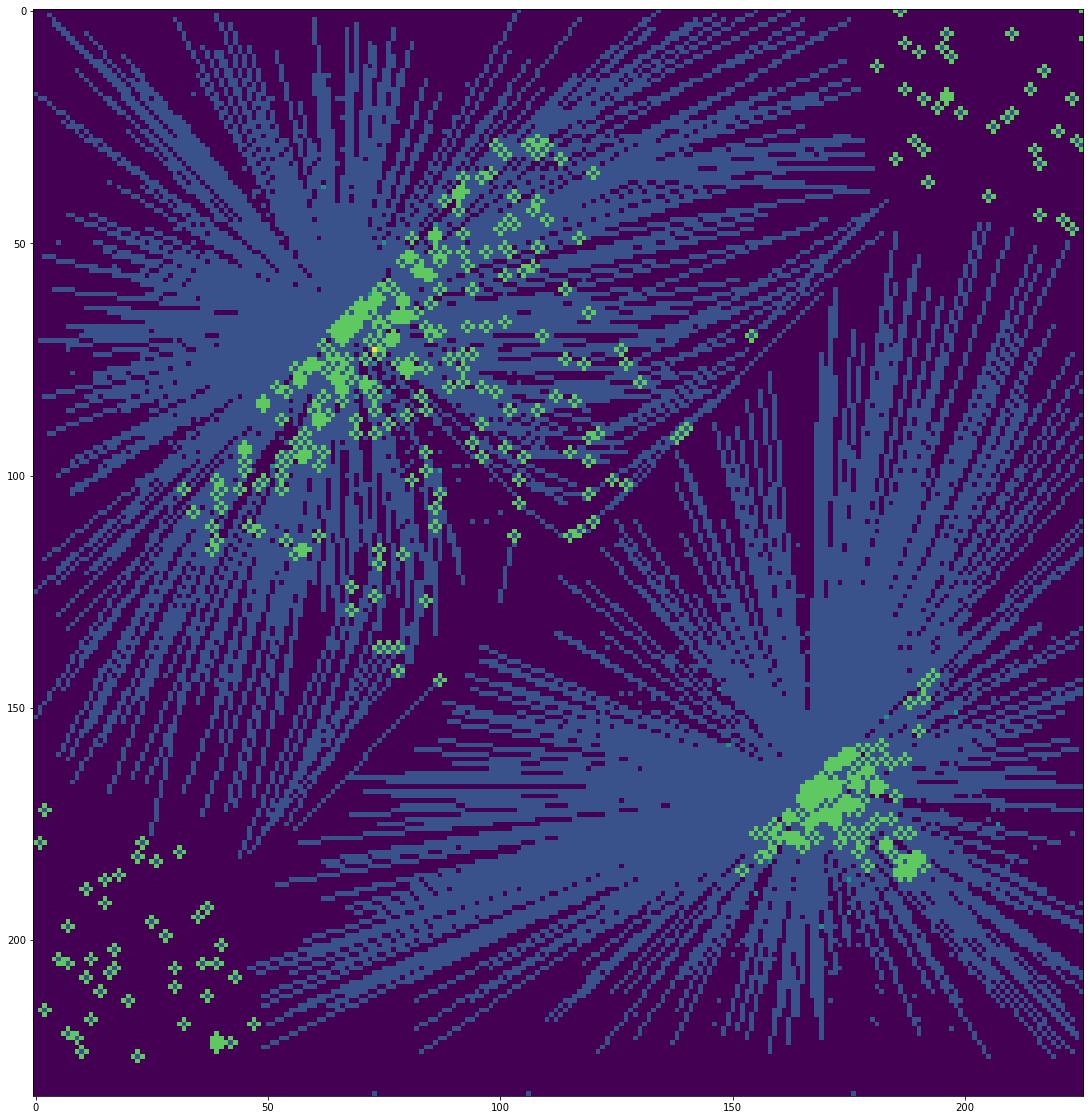

In [922]:
plt.figure(figsize=(20, 20))
plt.imshow(canvas)

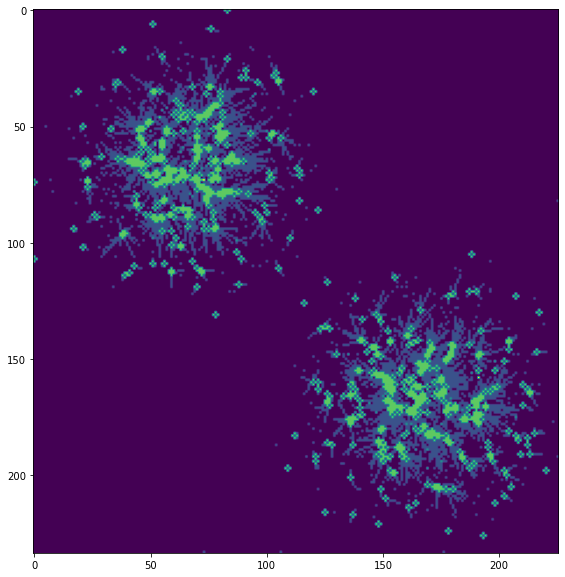

In [1831]:
plt.figure(figsize=(10, 10))
plt.imshow(canvas)